In [1]:
import json
import torch
import numpy as np
import random
import os
import pandas as pd
import sys
import random
import math
import argparse
import yaml
from pathlib import Path
import datetime
import wandb
import pickle
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from huggingface_hub import hf_hub_download

import plotly.graph_objects as go

from typing import List, Optional
import fire

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from typing import List

from fairscale.nn.model_parallel.initialize import (
    get_model_parallel_rank,
    initialize_model_parallel,
    model_parallel_is_initialized,
)

######################################################

# Parser
curr_date = datetime.datetime.now().strftime("%Y%m%d")

def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ("yes", "true", "t", "1"):
        return True
    elif v.lower() in ("no", "false", "f", "0"):
        return False
    else:
        raise argparse.ArgumentTypeError("Boolean value expected.")

/home/vdhanraj/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
curr_date = datetime.datetime.now().strftime("%Y%m%d")

# === Load config file (from train_encoders_and_decoders.py default values) ===
with open("train_encoders_and_decoders_default_config.yaml", "r") as f:
    config_defaults = yaml.safe_load(f)

# === Set all variables from config as globals ===
for k, v in config_defaults.items():
    globals()[k] = v

# === Load config file (from fine_tune_decoders.py default values) ===
with open("fine_tune_decoders_default_config.yaml", "r") as f:
    fine_tune_decoder_config_defaults = yaml.safe_load(f)

# Set all variables directly from config
for k, v in fine_tune_decoder_config_defaults.items():
    globals()[k] = v

# === Explicit overrides from code ===
master_port = "25000"
run_name = "1B_param_model"

curr_dir = '~/test/Neurosymbolic-LLM/Programs/'
git_dir = '~/test/Neurosymbolic-LLM'
ckpt_dir = '~/.llama/checkpoints/Llama3.2-1B-Instruct/original'
tokenizer_path = '~/.llama/checkpoints/Llama3.2-1B-Instruct/original/tokenizer.model'
encoder_path = "/home/vdhanraj/test/Neurosymbolic-LLM/Programs/models/encoders_1B_param_model.pth"
decoder_path = "/home/vdhanraj/test/Neurosymbolic-LLM/Programs/models/decoders_1B_param_model.pth"

max_batch_size = 1
n_samples = max_batch_size
train_data_rounds = 10000 // n_samples
val_data_rounds   = 100   // n_samples
test_data_rounds  = 1000  // n_samples
# train_data_rounds = 1000 // n_samples
# val_data_rounds   = 10   // n_samples
# test_data_rounds  = 100  // n_samples

symbolic_encoding_layer = 12
symbolic_decoding_layers = [12]
layer_numbers = range(0,17)
VSA_dim = 1024
model_dim = 2048
log_wandb = False

# === Path expansion for file/dir fields ===
curr_dir              = str(Path(curr_dir).expanduser())
git_dir               = str(Path(git_dir ).expanduser())
ckpt_dir              = str(Path(ckpt_dir).expanduser())
tokenizer_path        = str(Path(tokenizer_path).expanduser())
training_data_df_path = str(Path(training_data_df_path).expanduser()) if training_data_df_path else ''
val_data_df_path      = str(Path(val_data_df_path).expanduser()) if val_data_df_path else ''
testing_data_df_path  = str(Path(testing_data_df_path).expanduser()) if testing_data_df_path else ''

layer_numbers = torch.tensor(layer_numbers)
n_samples         = min(n_samples,         max_batch_size)
val_n_samples     = min(val_n_samples,     max_batch_size)
testing_n_samples = min(testing_n_samples, max_batch_size)

print("Configuration loaded successfully")
print(f"Run name: {run_name}")
print(f"Master port: {master_port}")
print(f"Model dimension: {model_dim}")
print(f"VSA dimension: {VSA_dim}")
print(f"Log to W&B: {log_wandb}")

sys.path.insert(0, git_dir)

from llama.encoder_decoder_networks import Encoder, Decoder, Encoder_Deep, Decoder_Deep, LastTokenTransformer
from llama.vsa_engine import *
from llama.utilities import *
from llama import Llama

print("LLaMA modules imported successfully")


Configuration loaded successfully
Run name: 1B_param_model
Master port: 25000
Model dimension: 2048
VSA dimension: 1024
Log to W&B: False
LLaMA modules imported successfully


In [3]:
if log_wandb:
    wandb.finish() # If there is an active current run, terminate it
    wandb.init(
        project = "Symbolic LLM Demo",
        name    = run_name,
    )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current device:", torch.cuda.get_device_name(torch.cuda.current_device()))

os.environ['RANK'] = "0"
os.environ['WORLD_SIZE'] = "1"
os.environ['MASTER_ADDR'] = "127.0.0.2"
os.environ['MASTER_PORT'] = master_port
os.environ['LOCAL_RANK']  = "0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

generator = Llama.build(
    ckpt_dir=ckpt_dir,
    tokenizer_path=tokenizer_path,
    max_seq_len=max_seq_len,
    max_batch_size=max_batch_size,
)

# Freeze the pretrained LLM
for param in generator.model.parameters():
    param.requires_grad = False


Current device: NVIDIA GeForce RTX 4090
> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1
Loaded in 4.32 seconds


In [4]:
possible_problems_str = "_".join(possible_problems)

if os.path.exists(f"{curr_dir}/VSA_library/symbolic_engine_VSA_dim_{VSA_dim}_max_digits_{max_digits}_problem_types_{possible_problems_str}.pt"):
    SE = torch.load(f"{curr_dir}/VSA_library/symbolic_engine_VSA_dim_{VSA_dim}"
                    f"_max_digits_{max_digits}_problem_types_{possible_problems_str}.pt", weights_only=False)
    print("Using pre-existing Semantic Engine object")
else:
    SE = SymbolicEngine(VSA_dim=VSA_dim, max_digits=max_digits, possible_problems=possible_problems, 
                        curr_dir=curr_dir)
    print("Creating and saving new existing Semantic Engine object")
    torch.save(SE, f"{curr_dir}/VSA_library/symbolic_engine_VSA_dim_{VSA_dim}_max_digits_{max_digits}_problem_types_{possible_problems_str}.pt")

generator.model.SE = SE

Using pre-existing Semantic Engine object


In [5]:
# For this demo, we will randomly generate data, so set the training, validation, and test dataframes to None

df_train = None
df_val = None
df_test = None

In [6]:
# training_encoder_data_loaders = generate_data_without_saving(generator=generator, mode='train',
#                                                              complexity=complexity, problem_type=problem_type,
#                                                              rounds=train_data_rounds, n_samples=n_samples,
#                                                              df_subset=df_train, layer_numbers=layer_numbers,
#                                                              tokens_to_keep=tokens_to_keep,
#                                                              batch_size=encoder_decoder_batch_size,
#                                                              gpu_seed=gpu_seed, verbose=verbose)
# print("Training data loaders for each layer have been created.")

# validation_encoder_data_loaders = generate_data_without_saving(generator=generator, mode='val',
#                                                               complexity=complexity, problem_type=problem_type,
#                                                               rounds=val_data_rounds, n_samples=n_samples,
#                                                               df_subset=df_val, layer_numbers=layer_numbers,
#                                                               tokens_to_keep=tokens_to_keep,
#                                                               batch_size=encoder_decoder_batch_size,
#                                                               gpu_seed=gpu_seed, verbose=verbose)
# print("Validation data loaders for each layer have been created.")

# testing_encoder_data_loaders = generate_data_without_saving(generator=generator, mode='test',
#                                                             complexity=complexity, problem_type=problem_type,
#                                                             rounds=test_data_rounds, n_samples=n_samples,
#                                                             df_subset=df_test, layer_numbers=layer_numbers,
#                                                             tokens_to_keep=tokens_to_keep,
#                                                             batch_size=encoder_decoder_batch_size,
#                                                             gpu_seed=gpu_seed, verbose=verbose)
# print("Testing data loaders for each layer have been created.")


In [7]:
save_dir = f"gathered_data_{run_name}"

os.makedirs(save_dir, exist_ok=True)
print("Data will be saved and read from:", save_dir)

generate_and_save_data(generator=generator, SE=SE, save_dir=save_dir, 
                       rounds=train_data_rounds, mode="train",  save_frequency=save_frequency,
                       complexity=complexity, n_samples=n_samples, problem_type=problem_type, df_subset=df_train,
                       tokens_to_keep=tokens_to_keep, calculate_end_index=calculate_end_index, verbose=True)
print("Training data gathering completed and saved to disk.")

generate_and_save_data(generator=generator, SE=SE, save_dir=save_dir, 
                       rounds=val_data_rounds,  mode="val", save_frequency=save_frequency,
                       complexity=complexity, n_samples=n_samples, problem_type=problem_type, df_subset=df_val,
                       tokens_to_keep=tokens_to_keep, calculate_end_index=calculate_end_index, verbose=True)
print("Validation data gathering completed and saved to disk.")

generate_and_save_data(generator=generator, SE=SE, save_dir=save_dir, 
                       rounds=test_data_rounds,  mode="test", save_frequency=save_frequency,
                       complexity=complexity, n_samples=n_samples, problem_type=problem_type, df_subset=df_test,
                       tokens_to_keep=tokens_to_keep, calculate_end_index=calculate_end_index, verbose=True)
print("Testing data gathering completed and saved to disk.")


Data will be saved and read from: gathered_data_1B_param_model
On Round Number: 50
On Round Number: 100
On Round Number: 150
On Round Number: 200
On Round Number: 250
On Round Number: 300
On Round Number: 350
On Round Number: 400
On Round Number: 450
On Round Number: 500
On Round Number: 550
On Round Number: 600
On Round Number: 650
On Round Number: 700
On Round Number: 750
On Round Number: 800
On Round Number: 850
On Round Number: 900
On Round Number: 950
On Round Number: 1000
On Round Number: 1050
On Round Number: 1100
On Round Number: 1150
On Round Number: 1200
On Round Number: 1250
On Round Number: 1300
On Round Number: 1350
On Round Number: 1400
On Round Number: 1450
On Round Number: 1500
On Round Number: 1550
On Round Number: 1600
On Round Number: 1650
On Round Number: 1700
On Round Number: 1750
On Round Number: 1800
On Round Number: 1850
On Round Number: 1900
On Round Number: 1950
On Round Number: 2000
On Round Number: 2050
On Round Number: 2100
On Round Number: 2150
On Round Nu

In [8]:
training_encoder_data_loaders = generate_data_loaders(mode='train', save_dir=save_dir, data_rounds=train_data_rounds, n_samples=n_samples, df_subset=df_train,
                                                      save_frequency=save_frequency, layer_numbers=layer_numbers, restrict_dataset=restrict_train_dataset, 
                                                      tokens_to_keep=tokens_to_keep, batch_size=encoder_decoder_batch_size, gpu_seed=gpu_seed, verbose=True)
print("Training data loaders for each layer have been created.")

validation_encoder_data_loaders = generate_data_loaders(mode='val', save_dir=save_dir, data_rounds=val_data_rounds, n_samples=n_samples, df_subset=df_val,
                                                        save_frequency=save_frequency, layer_numbers=layer_numbers, restrict_dataset=restrict_val_dataset, 
                                                        tokens_to_keep=tokens_to_keep, batch_size=encoder_decoder_batch_size, gpu_seed=gpu_seed, verbose=True)
print("Validation data loaders for each layer have been created.")

testing_encoder_data_loaders = generate_data_loaders(mode='test', save_dir=save_dir, data_rounds=test_data_rounds, n_samples=n_samples, df_subset=df_test,
                                                     save_frequency=save_frequency, layer_numbers=layer_numbers, restrict_dataset=restrict_test_dataset, 
                                                     tokens_to_keep=tokens_to_keep, batch_size=encoder_decoder_batch_size, gpu_seed=gpu_seed, verbose=True)
print("Testing data loaders for each layer have been created.")


--- On Layer Number: 0
On Round Number: 50
On Round Number: 100
On Round Number: 150
On Round Number: 200
On Round Number: 250
On Round Number: 300
On Round Number: 350
On Round Number: 400
On Round Number: 450
On Round Number: 500
On Round Number: 550
On Round Number: 600
On Round Number: 650
On Round Number: 700
On Round Number: 750
On Round Number: 800
On Round Number: 850
On Round Number: 900
On Round Number: 950
On Round Number: 1000
On Round Number: 1050
On Round Number: 1100
On Round Number: 1150
On Round Number: 1200
On Round Number: 1250
On Round Number: 1300
On Round Number: 1350
On Round Number: 1400
On Round Number: 1450
On Round Number: 1500
On Round Number: 1550
On Round Number: 1600
On Round Number: 1650
On Round Number: 1700
On Round Number: 1750
On Round Number: 1800
On Round Number: 1850
On Round Number: 1900
On Round Number: 1950
On Round Number: 2000
On Round Number: 2050
On Round Number: 2100
On Round Number: 2150
On Round Number: 2200
On Round Number: 2250
On Roun

On Round Number: 2900
On Round Number: 2950
On Round Number: 3000
On Round Number: 3050
On Round Number: 3100
On Round Number: 3150
On Round Number: 3200
On Round Number: 3250
On Round Number: 3300
On Round Number: 3350
On Round Number: 3400
On Round Number: 3450
On Round Number: 3500
On Round Number: 3550
On Round Number: 3600
On Round Number: 3650
On Round Number: 3700
On Round Number: 3750
On Round Number: 3800
On Round Number: 3850
On Round Number: 3900
On Round Number: 3950
On Round Number: 4000
On Round Number: 4050
On Round Number: 4100
On Round Number: 4150
On Round Number: 4200
On Round Number: 4250
On Round Number: 4300
On Round Number: 4350
On Round Number: 4400
On Round Number: 4450
On Round Number: 4500
On Round Number: 4550
On Round Number: 4600
On Round Number: 4650
On Round Number: 4700
On Round Number: 4750
On Round Number: 4800
On Round Number: 4850
On Round Number: 4900
On Round Number: 4950
On Round Number: 5000
On Round Number: 5050
On Round Number: 5100
On Round N

On Round Number: 9000
On Round Number: 9050
On Round Number: 9100
On Round Number: 9150
On Round Number: 9200
On Round Number: 9250
On Round Number: 9300
On Round Number: 9350
On Round Number: 9400
On Round Number: 9450
On Round Number: 9500
On Round Number: 9550
On Round Number: 9600
On Round Number: 9650
On Round Number: 9700
On Round Number: 9750
On Round Number: 9800
On Round Number: 9850
On Round Number: 9900
On Round Number: 9950
On Round Number: 10000
--- On Layer Number: 5
On Round Number: 50
On Round Number: 100
On Round Number: 150
On Round Number: 200
On Round Number: 250
On Round Number: 300
On Round Number: 350
On Round Number: 400
On Round Number: 450
On Round Number: 500
On Round Number: 550
On Round Number: 600
On Round Number: 650
On Round Number: 700
On Round Number: 750
On Round Number: 800
On Round Number: 850
On Round Number: 900
On Round Number: 950
On Round Number: 1000
On Round Number: 1050
On Round Number: 1100
On Round Number: 1150
On Round Number: 1200
On Rou

On Round Number: 5650
On Round Number: 5700
On Round Number: 5750
On Round Number: 5800
On Round Number: 5850
On Round Number: 5900
On Round Number: 5950
On Round Number: 6000
On Round Number: 6050
On Round Number: 6100
On Round Number: 6150
On Round Number: 6200
On Round Number: 6250
On Round Number: 6300
On Round Number: 6350
On Round Number: 6400
On Round Number: 6450
On Round Number: 6500
On Round Number: 6550
On Round Number: 6600
On Round Number: 6650
On Round Number: 6700
On Round Number: 6750
On Round Number: 6800
On Round Number: 6850
On Round Number: 6900
On Round Number: 6950
On Round Number: 7000
On Round Number: 7050
On Round Number: 7100
On Round Number: 7150
On Round Number: 7200
On Round Number: 7250
On Round Number: 7300
On Round Number: 7350
On Round Number: 7400
On Round Number: 7450
On Round Number: 7500
On Round Number: 7550
On Round Number: 7600
On Round Number: 7650
On Round Number: 7700
On Round Number: 7750
On Round Number: 7800
On Round Number: 7850
On Round N

On Round Number: 7500
On Round Number: 7550
On Round Number: 7600
On Round Number: 7650
On Round Number: 7700
On Round Number: 7750
On Round Number: 7800
On Round Number: 7850
On Round Number: 7900
On Round Number: 7950
On Round Number: 8000
On Round Number: 8050
On Round Number: 8100
On Round Number: 8150
On Round Number: 8200
On Round Number: 8250
On Round Number: 8300
On Round Number: 8350
On Round Number: 8400
On Round Number: 8450
On Round Number: 8500
On Round Number: 8550
On Round Number: 8600
On Round Number: 8650
On Round Number: 8700
On Round Number: 8750
On Round Number: 8800
On Round Number: 8850
On Round Number: 8900
On Round Number: 8950
On Round Number: 9000
On Round Number: 9050
On Round Number: 9100
On Round Number: 9150
On Round Number: 9200
On Round Number: 9250
On Round Number: 9300
On Round Number: 9350
On Round Number: 9400
On Round Number: 9450
On Round Number: 9500
On Round Number: 9550
On Round Number: 9600
On Round Number: 9650
On Round Number: 9700
On Round N

--- On Layer Number: 12
On Round Number: 50
On Round Number: 100
On Round Number: 150
On Round Number: 200
On Round Number: 250
On Round Number: 300
On Round Number: 350
On Round Number: 400
On Round Number: 450
On Round Number: 500
On Round Number: 550
On Round Number: 600
On Round Number: 650
On Round Number: 700
On Round Number: 750
On Round Number: 800
On Round Number: 850
On Round Number: 900
On Round Number: 950
On Round Number: 1000
On Round Number: 1050
On Round Number: 1100
On Round Number: 1150
On Round Number: 1200
On Round Number: 1250
On Round Number: 1300
On Round Number: 1350
On Round Number: 1400
On Round Number: 1450
On Round Number: 1500
On Round Number: 1550
On Round Number: 1600
On Round Number: 1650
On Round Number: 1700
On Round Number: 1750
On Round Number: 1800
On Round Number: 1850
On Round Number: 1900
On Round Number: 1950
On Round Number: 2000
On Round Number: 2050
On Round Number: 2100
On Round Number: 2150
On Round Number: 2200
On Round Number: 2250
On Rou

--- On Layer Number: 14
On Round Number: 50
On Round Number: 100
On Round Number: 150
On Round Number: 200
On Round Number: 250
On Round Number: 300
On Round Number: 350
On Round Number: 400
On Round Number: 450
On Round Number: 500
On Round Number: 550
On Round Number: 600
On Round Number: 650
On Round Number: 700
On Round Number: 750
On Round Number: 800
On Round Number: 850
On Round Number: 900
On Round Number: 950
On Round Number: 1000
On Round Number: 1050
On Round Number: 1100
On Round Number: 1150
On Round Number: 1200
On Round Number: 1250
On Round Number: 1300
On Round Number: 1350
On Round Number: 1400
On Round Number: 1450
On Round Number: 1500
On Round Number: 1550
On Round Number: 1600
On Round Number: 1650
On Round Number: 1700
On Round Number: 1750
On Round Number: 1800
On Round Number: 1850
On Round Number: 1900
On Round Number: 1950
On Round Number: 2000
On Round Number: 2050
On Round Number: 2100
On Round Number: 2150
On Round Number: 2200
On Round Number: 2250
On Rou

On Round Number: 1750
On Round Number: 1800
On Round Number: 1850
On Round Number: 1900
On Round Number: 1950
On Round Number: 2000
On Round Number: 2050
On Round Number: 2100
On Round Number: 2150
On Round Number: 2200
On Round Number: 2250
On Round Number: 2300
On Round Number: 2350
On Round Number: 2400
On Round Number: 2450
On Round Number: 2500
On Round Number: 2550
On Round Number: 2600
On Round Number: 2650
On Round Number: 2700
On Round Number: 2750
On Round Number: 2800
On Round Number: 2850
On Round Number: 2900
On Round Number: 2950
On Round Number: 3000
On Round Number: 3050
On Round Number: 3100
On Round Number: 3150
On Round Number: 3200
On Round Number: 3250
On Round Number: 3300
On Round Number: 3350
On Round Number: 3400
On Round Number: 3450
On Round Number: 3500
On Round Number: 3550
On Round Number: 3600
On Round Number: 3650
On Round Number: 3700
On Round Number: 3750
On Round Number: 3800
On Round Number: 3850
On Round Number: 3900
On Round Number: 3950
On Round N

On Round Number: 800
On Round Number: 850
On Round Number: 900
On Round Number: 950
On Round Number: 1000
--- On Layer Number: 12
On Round Number: 50
On Round Number: 100
On Round Number: 150
On Round Number: 200
On Round Number: 250
On Round Number: 300
On Round Number: 350
On Round Number: 400
On Round Number: 450
On Round Number: 500
On Round Number: 550
On Round Number: 600
On Round Number: 650
On Round Number: 700
On Round Number: 750
On Round Number: 800
On Round Number: 850
On Round Number: 900
On Round Number: 950
On Round Number: 1000
--- On Layer Number: 13
On Round Number: 50
On Round Number: 100
On Round Number: 150
On Round Number: 200
On Round Number: 250
On Round Number: 300
On Round Number: 350
On Round Number: 400
On Round Number: 450
On Round Number: 500
On Round Number: 550
On Round Number: 600
On Round Number: 650
On Round Number: 700
On Round Number: 750
On Round Number: 800
On Round Number: 850
On Round Number: 900
On Round Number: 950
On Round Number: 1000
--- On

In [9]:
load_pretrained_models = False

In [10]:
if not load_pretrained_models:
    encoders = torch.nn.ModuleList()
    for layer_id in layer_numbers:
        if tokens_to_keep == 1:
            #layer_encoder = Encoder_Deep(layer_id, model_dim, VSA_dim, model_dim*4).to(device)
            layer_encoder = Encoder(layer_id, model_dim, VSA_dim, ).to(device)
        else:
            layer_encoder = LastTokenTransformer(layer_id, model_dim, VSA_dim, num_layers=2, hidden_dim=512).to(device)
        encoders.append(layer_encoder)#, dtype=torch.float32))

    print("Trainable parameters per layer:", count_trainable_parameters(layer_encoder)) # Per Layer

    optimizers   = [optim.Adam(encoders[n].parameters(), lr=learning_rate) for n in range(len(layer_numbers))]
    criterion = nn.MSELoss()
    losses     = np.zeros((len(layer_numbers), training_epochs))
    val_losses = np.zeros((len(layer_numbers), training_epochs))
    running_losses = np.zeros((len(layer_numbers)))


Trainable parameters per layer: 2097152


In [11]:
if not load_pretrained_models:
    for i in range(training_epochs):
        if i in learning_rate_reduction_factors.keys():
            for param_group in optimizers[n].param_groups:
                param_group['lr'] = param_group['lr'] * learning_rate_reduction_factors[i]  # Set new learning rate
                print("Learning Rate changed to:", param_group['lr'])

        for n, n_layer in enumerate(layer_numbers):
            encoders[n].train()
            running_loss = 0
            total_norm = 0.0
            for batch_idx, (data, labels) in enumerate(training_encoder_data_loaders[n]):
                model_pred = encoders[n](data)
                loss = torch.sqrt(criterion(model_pred, labels))
                loss.backward()
                tn = 0
                for p in encoders[n].parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        tn += param_norm.item() ** 2
                total_norm += tn ** 0.5
                optimizers[n].step()
                optimizers[n].zero_grad()
                running_loss += loss.item()
            running_loss /= (batch_idx + 1)
            running_losses[n] = running_loss
            total_norm   /= (batch_idx + 1)
            losses[n][i] = running_loss

            v_predictions = []
            v_targets     = []

            encoders.eval()

            running_loss = 0
            with torch.no_grad():
                for batch_idx, (data, labels) in enumerate(validation_encoder_data_loaders[n]):
                    model_pred = encoders[n](data)
                    loss = torch.sqrt(criterion(model_pred, labels))
                    v_predictions += [model_pred]
                    v_targets     += [labels]
                    running_loss  += loss.item()

            running_loss /= (batch_idx + 1)
            val_losses[n][i] = running_loss

            v_predictions = torch.cat(v_predictions, dim=0)
            v_targets     = torch.cat(v_targets, dim=0)

            v_digit_predictions_n1 = SE.decode_digits(v_predictions.type_as(SE.vectors[SE.VSA_n1]), SE.VSA_n1)
            v_digit_labels_n1      = SE.decode_digits(v_targets.    type_as(SE.vectors[SE.VSA_n1]), SE.VSA_n1)
            v_digit_predictions_n2 = SE.decode_digits(v_predictions.type_as(SE.vectors[SE.VSA_n2]), SE.VSA_n2)
            v_digit_labels_n2      = SE.decode_digits(v_targets.    type_as(SE.vectors[SE.VSA_n2]), SE.VSA_n2)

            average_correct_digits = ((v_digit_predictions_n1 == v_digit_labels_n1).sum(axis=1).float().mean().detach().cpu().item() + 
                                      (v_digit_predictions_n2 == v_digit_labels_n2).sum(axis=1).float().mean().detach().cpu().item()) / 2

            error_per_digit = ((v_digit_predictions_n1 == v_digit_labels_n1).sum(axis=0).detach().cpu() / len(v_digit_predictions_n1) + 
                               (v_digit_predictions_n2 == v_digit_labels_n2).sum(axis=0).detach().cpu() / len(v_digit_predictions_n2)) / 2

            if not i % train_freq_print:
                print(f"    └─ L{n_layer}:, validation average correct digits: {average_correct_digits}, validation accuracy per digit: {error_per_digit}")

            encoders.train()

        if not i % train_freq_print:
            print("Epoch:", i, f"Running Loss: {running_losses.mean()}\t Validation Loss: {val_losses[:,i].mean()}\tTotal gradient norm: {total_norm}\t")
else:
    encoder_path = hf_hub_download(repo_id="vdhanraj/neurosymbolic-llm", filename="encoders_seed_42.pth")
    decoder_path = hf_hub_download(repo_id="vdhanraj/neurosymbolic-llm", filename="decoders_seed_42_finetuned.pth")

    encoders = torch.load(encoder_path, weights_only=False)
    decoders = torch.load(decoder_path, weights_only=False)


    └─ L0:, validation average correct digits: 2.3249999284744263, validation accuracy per digit: tensor([0.1152, 0.0801, 0.1299, 1.0000, 1.0000])
    └─ L1:, validation average correct digits: 2.3249999284744263, validation accuracy per digit: tensor([0.1152, 0.0801, 0.1299, 1.0000, 1.0000])
    └─ L2:, validation average correct digits: 2.3249999284744263, validation accuracy per digit: tensor([0.1152, 0.0801, 0.1299, 1.0000, 1.0000])
    └─ L3:, validation average correct digits: 2.3249999284744263, validation accuracy per digit: tensor([0.1152, 0.0801, 0.1299, 1.0000, 1.0000])
    └─ L4:, validation average correct digits: 2.3249999284744263, validation accuracy per digit: tensor([0.1152, 0.0801, 0.1299, 1.0000, 1.0000])
    └─ L5:, validation average correct digits: 2.3249999284744263, validation accuracy per digit: tensor([0.1152, 0.0801, 0.1299, 1.0000, 1.0000])
    └─ L6:, validation average correct digits: 2.3249999284744263, validation accuracy per digit: tensor([0.1152, 0.08

    └─ L3:, validation average correct digits: 2.444999933242798, validation accuracy per digit: tensor([0.1152, 0.0801, 0.2500, 1.0000, 1.0000])
    └─ L4:, validation average correct digits: 2.609999895095825, validation accuracy per digit: tensor([0.1250, 0.1001, 0.3848, 1.0000, 1.0000])
    └─ L5:, validation average correct digits: 2.799999952316284, validation accuracy per digit: tensor([0.1992, 0.1602, 0.4395, 1.0000, 1.0000])
    └─ L6:, validation average correct digits: 2.615000009536743, validation accuracy per digit: tensor([0.1445, 0.1001, 0.3691, 1.0000, 1.0000])
    └─ L7:, validation average correct digits: 2.6449999809265137, validation accuracy per digit: tensor([0.1445, 0.1050, 0.3945, 1.0000, 1.0000])
    └─ L8:, validation average correct digits: 2.6049998998641968, validation accuracy per digit: tensor([0.1299, 0.1050, 0.3711, 1.0000, 1.0000])
    └─ L9:, validation average correct digits: 2.7599998712539673, validation accuracy per digit: tensor([0.1748, 0.1553, 

    └─ L6:, validation average correct digits: 2.6200000047683716, validation accuracy per digit: tensor([0.1445, 0.1104, 0.3633, 1.0000, 1.0000])
    └─ L7:, validation average correct digits: 2.684999942779541, validation accuracy per digit: tensor([0.1650, 0.1250, 0.3945, 1.0000, 1.0000])
    └─ L8:, validation average correct digits: 2.6399998664855957, validation accuracy per digit: tensor([0.1543, 0.0996, 0.3848, 1.0000, 1.0000])
    └─ L9:, validation average correct digits: 2.799999952316284, validation accuracy per digit: tensor([0.2002, 0.1650, 0.4355, 1.0000, 1.0000])
    └─ L10:, validation average correct digits: 3.2849998474121094, validation accuracy per digit: tensor([0.3047, 0.3301, 0.6484, 1.0000, 1.0000])
    └─ L11:, validation average correct digits: 3.875, validation accuracy per digit: tensor([0.5781, 0.5234, 0.7695, 1.0000, 1.0000])
    └─ L12:, validation average correct digits: 4.839999675750732, validation accuracy per digit: tensor([0.9648, 0.9141, 0.9609, 1

    └─ L9:, validation average correct digits: 2.794999837875366, validation accuracy per digit: tensor([0.2002, 0.1650, 0.4297, 1.0000, 1.0000])
    └─ L10:, validation average correct digits: 3.3149999380111694, validation accuracy per digit: tensor([0.3164, 0.3555, 0.6445, 1.0000, 1.0000])
    └─ L11:, validation average correct digits: 3.914999842643738, validation accuracy per digit: tensor([0.6172, 0.5156, 0.7812, 1.0000, 1.0000])
    └─ L12:, validation average correct digits: 4.84499979019165, validation accuracy per digit: tensor([0.9688, 0.9102, 0.9648, 1.0000, 1.0000])
    └─ L13:, validation average correct digits: 4.879999876022339, validation accuracy per digit: tensor([0.9609, 0.9297, 0.9922, 1.0000, 1.0000])
    └─ L14:, validation average correct digits: 4.759999752044678, validation accuracy per digit: tensor([0.9414, 0.8594, 0.9609, 1.0000, 1.0000])
    └─ L15:, validation average correct digits: 4.704999923706055, validation accuracy per digit: tensor([0.9609, 0.789

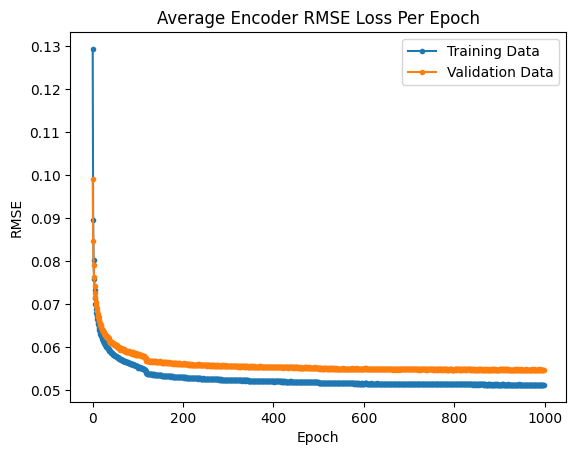

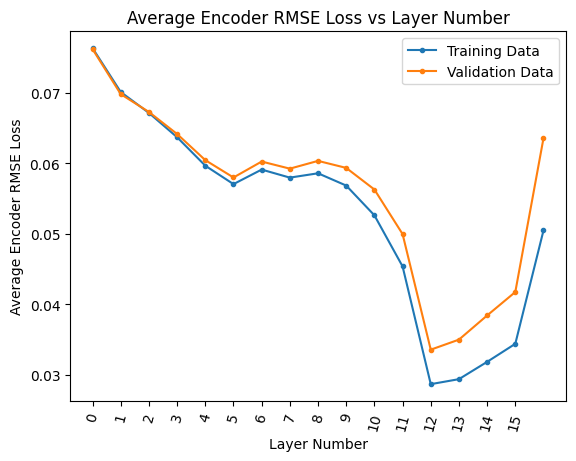

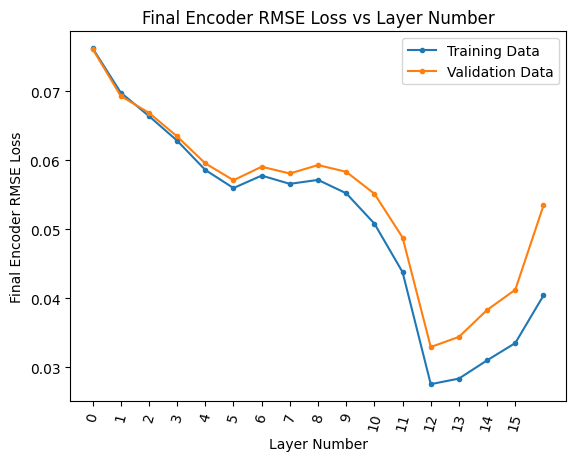

In [12]:
if not load_pretrained_models:
    plt.plot(losses.mean(axis=0)[:i], marker=".")
    plt.plot(val_losses.mean(axis=0)[:i], marker=".")
    plt.title("Average Encoder RMSE Loss Per Epoch")
    plt.ylabel("RMSE")
    plt.xlabel("Epoch")
    plt.legend(['Training Data', 'Validation Data'])
    if log_wandb:
        wandb.log({f"Average Encoder RMSE Loss Per Epoch": wandb.Image(plt)})
    else:
        plt.show()
    plt.close()


    plt.plot(losses.T[:i].mean(axis=0), marker=".")
    plt.plot(val_losses.T[:i].mean(axis=0), marker=".")
    x_ticks = np.arange(0, len(losses.T.mean(axis=0)[:-1]), 1)
    plt.xticks(x_ticks, rotation=75)
    plt.title("Average Encoder RMSE Loss vs Layer Number")
    plt.ylabel("Average Encoder RMSE Loss")
    plt.xlabel("Layer Number")
    plt.legend(['Training Data', 'Validation Data'])
    if log_wandb:
        wandb.log({f"Average Encoder RMSE Loss vs Layer Number": wandb.Image(plt)})
    else:
        plt.show()
    plt.close()

    plt.plot(losses.T[i], marker=".")
    plt.plot(val_losses.T[i], marker=".")
    x_ticks = np.arange(0, len(losses.T.mean(axis=0)[:-1]), 1)
    plt.xticks(x_ticks, rotation=75)
    plt.title("Final Encoder RMSE Loss vs Layer Number")
    plt.ylabel("Final Encoder RMSE Loss")
    plt.xlabel("Layer Number")
    plt.legend(['Training Data', 'Validation Data'])
    if log_wandb:
        wandb.log({f"Final Encoder RMSE Loss vs Layer Number": wandb.Image(plt)})
    else:
        plt.show()
    plt.close()


In [14]:
print("Decoder training starting")
if not load_pretrained_models:

    for n, n_layer in enumerate(layer_numbers):
        for param in encoders[n].parameters():
            param.requires_grad = False


    decoders = torch.nn.ModuleList()
    for layer_id in layer_numbers:
        #layer_decoder = Decoder_Deep(layer_id, VSA_dim, model_dim, model_dim*2).to(device)
        layer_decoder = Decoder(layer_id, VSA_dim, model_dim).to(device)
        decoders.append(layer_decoder)#, dtype=torch.float32))


    decoding_optimizers = [optim.Adam(decoders[n].parameters(), lr=decoding_learning_rate) for n in range(len(layer_numbers))]
    decoding_criterion  = nn.MSELoss()
    decoding_losses     = np.zeros((len(layer_numbers), decoding_epochs))
    val_decoding_losses = np.zeros((len(layer_numbers), decoding_epochs))
    decoding_running_losses = np.zeros((len(layer_numbers)))


Decoder training starting


In [16]:
if not load_pretrained_models:
    for j in range(decoding_epochs):
        if j in decoding_learning_rate_reduction_factors.keys():
            for param_group in decoding_optimizers[n].param_groups:
                param_group['lr'] = param_group['lr'] * decoding_learning_rate_reduction_factors[j]  # Set new learning rate
                print("Learning Rate changed to:", param_group['lr'])
        for n, n_layer in enumerate(layer_numbers):
            decoding_running_loss = 0
            total_norm = 0.0
            for batch_idx, (data, labels) in enumerate(training_encoder_data_loaders[n]):
                latent_representation = encoders[n](data)

                predicted_hidden_state = decoders[n](latent_representation)

                if tokens_to_keep != 1:
                    target = data[:,-1,:]
                else:
                    target = data

                loss = torch.sqrt(criterion(predicted_hidden_state, target))
                loss.backward()
                tn = 0
                for p in decoders[n].parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2)
                        tn += param_norm.item() ** 2
                total_norm += tn ** 0.5
                decoding_optimizers[n].step()
                decoding_optimizers[n].zero_grad()
                decoding_running_loss += loss.item()
            decoding_running_loss /= (batch_idx + 1)
            decoding_running_losses[n] = decoding_running_loss
            total_norm   /= (batch_idx + 1)
            decoding_losses[n][j] = decoding_running_loss

            val_decoding_running_loss = 0

            for batch_idx, (data, labels) in enumerate(validation_encoder_data_loaders[n]):
                latent_representation = encoders[n](data)

                predicted_hidden_state = decoders[n](latent_representation)

                if tokens_to_keep != 1:
                    target = data[:,-1,:]
                else:
                    target = data

                loss = torch.sqrt(criterion(predicted_hidden_state, target))
                val_decoding_running_loss += loss.item()

            val_decoding_running_loss /= (batch_idx + 1)
            val_decoding_losses[n][j] = val_decoding_running_loss

        if not j % train_freq_print and j:
            print("Epoch:", j, f"Running Loss: {decoding_running_losses.mean()}\t Validation Loss: {val_decoding_losses[:,j].mean()}\tTotal gradient norm: {total_norm}\t")


Learning Rate changed to: 0.0001
Learning Rate changed to: 5e-05
Learning Rate changed to: 2.5e-05
Epoch: 100 Running Loss: 0.09457118090461282	 Validation Loss: 0.09642634672277114	Total gradient norm: 0.01141357421875	
Epoch: 200 Running Loss: 0.09393310266382555	 Validation Loss: 0.09573263280531939	Total gradient norm: 0.0113922119140625	
Learning Rate changed to: 1e-05
Epoch: 300 Running Loss: 0.09358428506290212	 Validation Loss: 0.09535576315487132	Total gradient norm: 0.011395263671875	
Epoch: 400 Running Loss: 0.09327601544997272	 Validation Loss: 0.09519307753619026	Total gradient norm: 0.011407470703125	
Epoch: 500 Running Loss: 0.0932514976052677	 Validation Loss: 0.09510163699879366	Total gradient norm: 0.0114013671875	
Epoch: 600 Running Loss: 0.09308590327992158	 Validation Loss: 0.09501277699190028	Total gradient norm: 0.011431884765625	
Epoch: 700 Running Loss: 0.09305918917936437	 Validation Loss: 0.09497367634492762	Total gradient norm: 0.011407470703125	
Epoch: 800 

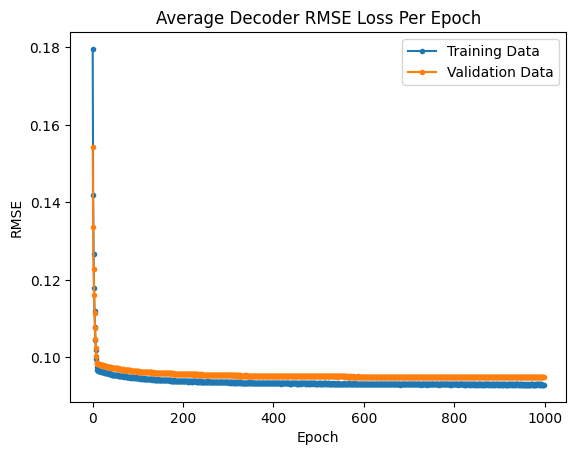

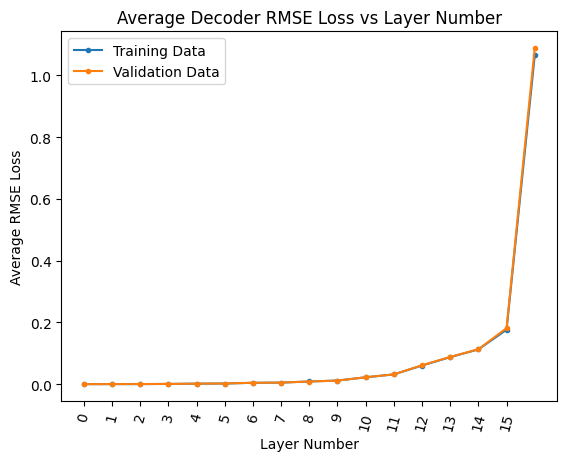

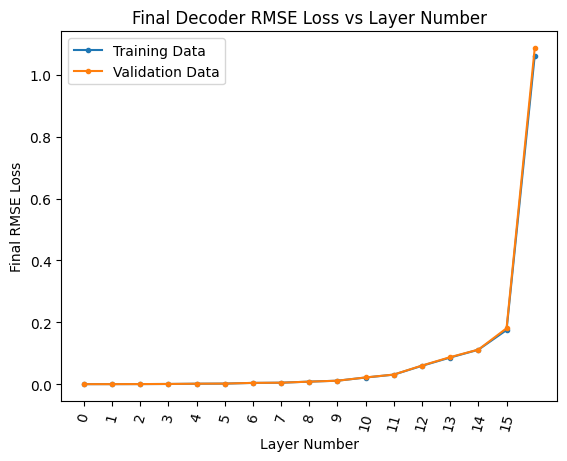

In [17]:
if not load_pretrained_models:
    plt.plot(decoding_losses.mean(axis=0)[:j], marker=".")
    plt.plot(val_decoding_losses.mean(axis=0)[:j], marker=".")
    plt.title("Average Decoder RMSE Loss Per Epoch")
    plt.ylabel("RMSE")
    plt.xlabel("Epoch")
    plt.legend(['Training Data', 'Validation Data'])
    if log_wandb:
        wandb.log({f"Average Decoder RMSE Loss Per Epoch": wandb.Image(plt)})
    else:
        plt.show()
    plt.close()

    plt.plot(decoding_losses.T[:j].mean(axis=0), marker=".")
    plt.plot(val_decoding_losses.T[:j].mean(axis=0), marker=".")
    x_ticks = np.arange(0, len(decoding_losses.T.mean(axis=0)[:-1]), 1)
    plt.xticks(x_ticks, rotation=75)
    plt.title("Average Decoder RMSE Loss vs Layer Number")
    plt.ylabel("Average RMSE Loss")
    plt.xlabel("Layer Number")
    plt.legend(['Training Data', 'Validation Data'])
    if log_wandb:
        wandb.log({f"Average Decoder RMSE Loss vs Layer Number": wandb.Image(plt)})
    else:
        plt.show()
    plt.close()

    plt.plot(decoding_losses.T[j], marker=".")
    plt.plot(val_decoding_losses.T[j], marker=".")
    x_ticks = np.arange(0, len(decoding_losses.T.mean(axis=0)[:-1]), 1)
    plt.xticks(x_ticks, rotation=75)
    plt.title("Final Decoder RMSE Loss vs Layer Number")
    plt.ylabel("Final RMSE Loss")
    plt.xlabel("Layer Number")
    plt.legend(['Training Data', 'Validation Data'])
    if log_wandb:
        wandb.log({f"Final Decoder RMSE Loss vs Layer Number": wandb.Image(plt)})
    else:
        plt.show()
    plt.close()


In [18]:
if not load_pretrained_models:
    if not os.path.exists(f"{curr_dir}/models"):
        os.mkdir(f"{curr_dir}/models")
    torch.save(encoders.state_dict(), f"{curr_dir}/models/encoders_state_dict_{run_name}.pth")
    torch.save(encoders,              f"{curr_dir}/models/encoders_{run_name}.pth")
    print("Saved:", f"{curr_dir}/models/encoders_state_dict_{run_name}.pth", "and", f"models/encoders_{run_name}.pth")
    torch.save(decoders.state_dict(), f"{curr_dir}/models/decoders_state_dict_{run_name}.pth")
    torch.save(decoders,              f"{curr_dir}/models/decoders_{run_name}.pth")
    print("Saved:", f"{curr_dir}/models/decoders_state_dict_{run_name}.pth", "and", f"models/decoders_{run_name}.pth")
else:
    encoder_path = hf_hub_download(repo_id="vdhanraj/neurosymbolic-llm", filename="encoders_1B_param_model.pth")
    decoder_path = hf_hub_download(repo_id="vdhanraj/neurosymbolic-llm", filename="decoders_1B_param_model.pth")

    encoders = torch.load(encoder_path, weights_only=False)
    decoders = torch.load(decoder_path, weights_only=False)
    print("Loaded encoders_1B_param_model.pth and decoders_1B_param_model.pth from huggingface")


Saved: /home/vdhanraj/test/Neurosymbolic-LLM/Programs/models/encoders_state_dict_1B_param_model.pth and models/encoders_1B_param_model.pth
Saved: /home/vdhanraj/test/Neurosymbolic-LLM/Programs/models/decoders_state_dict_1B_param_model.pth and models/decoders_1B_param_model.pth


In [19]:
print(" ------ Running Error Statistics for Testing Data ------ ")

#errors_per_pt = {layer_num.item() : {pt: [] for pt in possible_problems} for n, layer_num in enumerate(layer_numbers)}
errors_per_pt = {pt: {layer_num.item(): [] for n, layer_num in enumerate(layer_numbers)} for pt in possible_problems}

VSA_predictions = []
label_VSAs      = []
rows_to_print  = 0
verbose = 1 # 0, 1, 2
errors = np.zeros(len(layer_numbers))
lowest_error_layer = 0
lowest_error       = complexity + 1
lowest_pt_error    = np.inf
calculate_digit_error = True # Measure total number of errors per digit
per_digit_errors = torch.zeros((len(layer_numbers), SE.max_digits))
exponents = torch.tensor([10 ** i for i in range(SE.max_digits)])
with torch.no_grad():
    for n, layer in enumerate(layer_numbers):
        row_count = 0
        if verbose:
            print("--------- Layer", layer.item(), "---------")
        e = 0
        for batch_idx, (data, labels) in enumerate(testing_encoder_data_loaders[n]):
            row_count += len(data)
            pred = encoders[n](data)
            decoded_n1 = (SE.decode_digits(pred.  type_as(SE.vectors[SE.VSA_n1]), SE.VSA_n1) * exponents).sum(axis=1)
            decoded_n2 = (SE.decode_digits(pred.  type_as(SE.vectors[SE.VSA_n2]), SE.VSA_n2) * exponents).sum(axis=1)
            actual_n1  = (SE.decode_digits(labels.type_as(SE.vectors[SE.VSA_n1]), SE.VSA_n1) * exponents).sum(axis=1)
            actual_n2  = (SE.decode_digits(labels.type_as(SE.vectors[SE.VSA_n2]), SE.VSA_n2) * exponents).sum(axis=1)
            decoded_problem_types, _, _ = SE.decode_problem_type(pred)
            actual_problem_types, _, _  = SE.decode_problem_type(labels)
            if calculate_digit_error:
                n1_batch_error, n1_per_digit_error = SE.digit_error(decoded_n1, actual_n1, error_per_digit=calculate_digit_error, verbose=verbose)
                n2_batch_error, n2_per_digit_error = SE.digit_error(decoded_n2, actual_n2, error_per_digit=calculate_digit_error, verbose=verbose)
                batch_error = (n1_batch_error + n2_batch_error) / 2 * len(data) / (test_data_rounds * max_batch_size)
                per_digit_error = (n1_per_digit_error + n2_per_digit_error) / 2 * len(data) / (test_data_rounds * max_batch_size)
                #print(per_digit_error)
                per_digit_errors[layer.item()] += per_digit_error
            else:
                batch_error = SE.digit_error(decoded_n1, actual_n1, verbose=verbose) + SE.digit_error(decoded_n2, actual_n2, verbose=verbose)
                batch_error = batch_error / 2 * len(data) / (test_data_rounds * max_batch_size)
            for k, curr_pt in enumerate(actual_problem_types):
                errors_per_pt[curr_pt][layer.item()] += [batch_error[k].item()]
            for r in range(rows_to_print):
                print("Decoded symbolic encodings: first number:",  decoded_n1[r], "second number:", decoded_n2[r])
                print("Actual           encodings: first number:",  actual_n1[r],  "second number:", actual_n2[r])
                print("Decoded problem type:", decoded_problem_types[r])
                print("Actual  problem type:", actual_problem_types[r])
                #print(" --------- Error:", decoded_n1[r]-actual_n1[r], decoded_n2[r]-actual_n2[r], )
            e += batch_error.float().mean().item() 

        errors[n] = e
        per_digit_errors[layer.item()] = per_digit_errors[layer.item()] / row_count
        problem_type_error = (decoded_problem_types != actual_problem_types).sum()
        if e < lowest_error:
            lowest_error_layer = layer
            lowest_error       = e
            lowest_pt_error    = problem_type_error

        print("Average Error:", errors[n], "digits out of", complexity+1)
        print("Average Problem Type Error:", problem_type_error, "out of", len(labels))
        # Divide per_digit_errors by row_count and by 2 in order to get per digit error
        print("Average Error Rate per Digit:", per_digit_errors[layer.item()])


 ------ Running Error Statistics for Testing Data ------ 
--------- Layer 0 ---------
Average Error: 2.7075083255767822 digits out of 3
Average Problem Type Error: 430 out of 488
Average Error Rate per Digit: tensor([0.4531, 0.4512, 0.4473, 0.0000, 0.0000], device='cuda:0')
--------- Layer 1 ---------
Average Error: 2.7070120573043823 digits out of 3
Average Problem Type Error: 0 out of 488
Average Error Rate per Digit: tensor([0.4531, 0.4512, 0.4473, 0.0000, 0.0000], device='cuda:0')
--------- Layer 2 ---------
Average Error: 2.6715070009231567 digits out of 3
Average Problem Type Error: 0 out of 488
Average Error Rate per Digit: tensor([0.4531, 0.4512, 0.4297, 0.0000, 0.0000], device='cuda:0')
--------- Layer 3 ---------
Average Error: 2.5830191373825073 digits out of 3
Average Problem Type Error: 0 out of 488
Average Error Rate per Digit: tensor([0.4531, 0.4512, 0.3887, 0.0000, 0.0000], device='cuda:0')
--------- Layer 4 ---------
Average Error: 2.3735064268112183 digits out of 3
Av

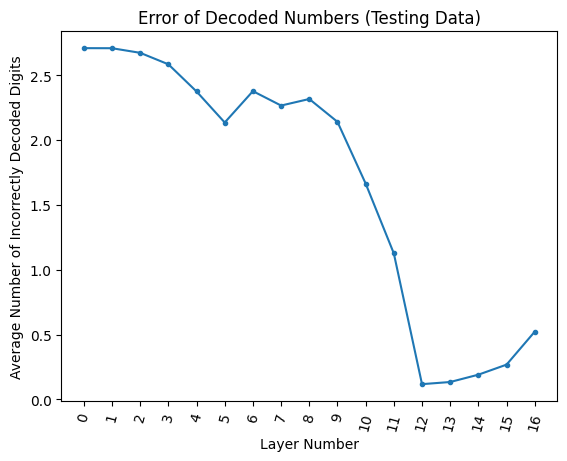

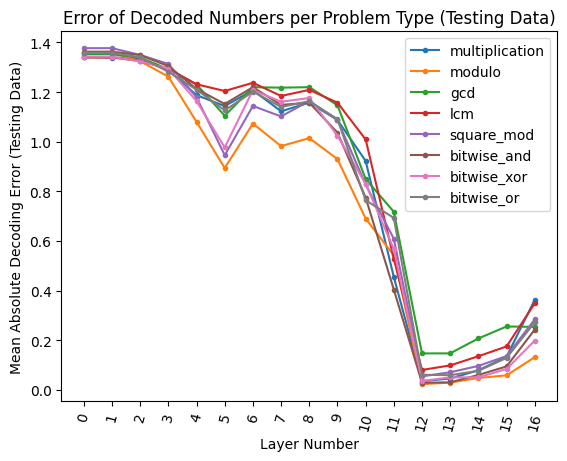

In [20]:
x_ticks = np.arange(layer_numbers.cpu()[0].item(), layer_numbers.cpu()[0].item() + len(layer_numbers), 1)
plt.plot(x_ticks, errors, marker=".")
plt.xticks(x_ticks, rotation=75)
plt.title("Error of Decoded Numbers (Testing Data)")
plt.ylabel("Average Number of Incorrectly Decoded Digits")
plt.xlabel("Layer Number")
plt.grid(False)
if log_wandb:
    wandb.log({f"Error of Decoded Numbers (Testing Data)": wandb.Image(plt)})
    wandb.log({f"Error Matrix (Testing Data)": errors})
else:
    plt.show()
plt.close()

for pt in problem_type:
    x_ticks = np.arange(layer_numbers.cpu()[0].item(), layer_numbers.cpu()[0].item() + len(layer_numbers), 1)
    pt_error = [np.mean(errors_per_pt[pt][ln]) for ln in errors_per_pt[pt]]
    plt.plot(x_ticks, pt_error, marker=".")
    plt.xticks(x_ticks, rotation=75)
    #plt.close()
plt.title(f"Error of Decoded Numbers per Problem Type (Testing Data)")
plt.ylabel("Mean Absolute Decoding Error (Testing Data)")
plt.xlabel("Layer Number")
plt.legend(problem_type)
plt.grid(False)
if log_wandb:
    wandb.log({f"Error of Decoded Numbers per Problem Type (Testing Data)": wandb.Image(plt)})
    wandb.log({f"Error per Problem Type (Testing Data)": errors_per_pt})
else:
    plt.show()
plt.close()


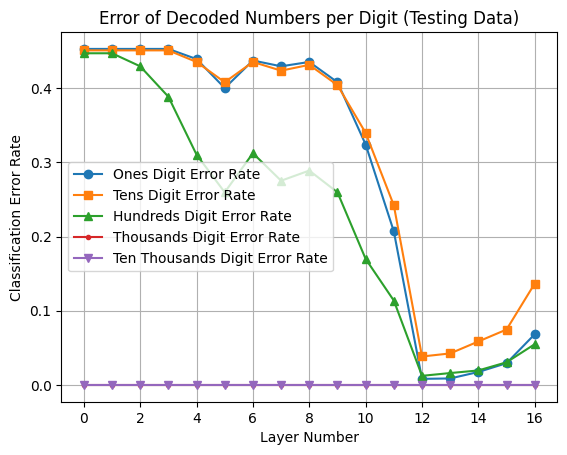

Minimum Error: 0.11749579757452011 and problem type error: 0 at layer 12


In [21]:
labels = ['Ones Digit Error Rate',
          'Tens Digit Error Rate',
          'Hundreds Digit Error Rate',
          'Thousands Digit Error Rate',
          'Ten Thousands Digit Error Rate',
          'Hundred Thousands Digit Error Rate',
          'Millions Digit Error Rate',
          'Ten Millions Digit Error Rate',
          'Hundred Millions Digit Error Rate',
          ]
markers = ["o", "s", "^", 
           ".", "v", "*", 
           "<", ">", "1"]

for n, digit in enumerate(per_digit_errors.float().cpu().numpy().T):
    plt.plot(layer_numbers.cpu(), digit, label=labels[n], marker=markers[n])

plt.title(f"Error of Decoded Numbers per Digit (Testing Data)")
plt.xlabel('Layer Number')
plt.ylabel('Classification Error Rate')
plt.legend()
plt.grid(True)
if log_wandb:
    wandb.log({f"Error of Decoded Numbers per Digit (Testing Data)": wandb.Image(plt)})
    wandb.log({f"Error per Digit (Testing Data)": per_digit_errors.float().cpu().numpy().T})
else:
    plt.show()
plt.close()

print("Minimum Error:", lowest_error, "and problem type error:", problem_type_error, "at layer", lowest_error_layer.item())#, ", Current running loss:", running_losses[lowest_error_layer.item()])


In [22]:
print(" ------ Running Error Statistics for Training Data ------ ")

errors_per_pt = {pt: {layer_num.item(): [] for n, layer_num in enumerate(layer_numbers)} for pt in possible_problems}

VSA_predictions = []
label_VSAs      = []
rows_to_print  = 0
verbose = 1 # 0, 1, 2
errors = np.zeros(len(layer_numbers))
lowest_error_layer = 0
lowest_error       = complexity + 1
lowest_pt_error    = np.inf
calculate_digit_error = True # Measure total number of errors per digit
per_digit_errors = torch.zeros((len(layer_numbers), SE.max_digits))
exponents = torch.tensor([10 ** i for i in range(SE.max_digits)])
with torch.no_grad():
    for n, layer in enumerate(layer_numbers):
        row_count = 0
        if verbose:
            print("--------- Layer", layer.item(), "---------")
        e = 0
        for batch_idx, (data, labels) in enumerate(training_encoder_data_loaders[n]):
            row_count += len(data)
            pred = encoders[n](data)
            decoded_n1 = (SE.decode_digits(pred.  type_as(SE.vectors[SE.VSA_n1]), SE.VSA_n1) * exponents).sum(axis=1)
            decoded_n2 = (SE.decode_digits(pred.  type_as(SE.vectors[SE.VSA_n2]), SE.VSA_n2) * exponents).sum(axis=1)
            actual_n1  = (SE.decode_digits(labels.type_as(SE.vectors[SE.VSA_n1]), SE.VSA_n1) * exponents).sum(axis=1)
            actual_n2  = (SE.decode_digits(labels.type_as(SE.vectors[SE.VSA_n2]), SE.VSA_n2) * exponents).sum(axis=1)
            decoded_problem_types, _, _ = SE.decode_problem_type(pred)
            actual_problem_types, _, _  = SE.decode_problem_type(labels)
            if calculate_digit_error:
                n1_batch_error, n1_per_digit_error = SE.digit_error(decoded_n1, actual_n1, error_per_digit=calculate_digit_error, verbose=verbose)
                n2_batch_error, n2_per_digit_error = SE.digit_error(decoded_n2, actual_n2, error_per_digit=calculate_digit_error, verbose=verbose)
                batch_error = (n1_batch_error + n2_batch_error) / 2 * len(data) / (train_data_rounds * max_batch_size)
                per_digit_error = (n1_per_digit_error + n2_per_digit_error) / 2 * len(data) / (train_data_rounds * max_batch_size)
                #print(per_digit_error)
                per_digit_errors[layer.item()] += per_digit_error
            else:
                batch_error = SE.digit_error(decoded_n1, actual_n1, verbose=verbose) + SE.digit_error(decoded_n2, actual_n2, verbose=verbose)
                batch_error = batch_error / 2 * len(data) / (train_data_rounds * max_batch_size)
            for k, curr_pt in enumerate(actual_problem_types):
                errors_per_pt[curr_pt][layer.item()] += [batch_error[k].item()]
            for r in range(rows_to_print):
                print("Decoded symbolic encodings: first number:",  decoded_n1[r], "second number:", decoded_n2[r])
                print("Actual           encodings: first number:",  actual_n1[r],  "second number:", actual_n2[r])
                print("Decoded problem type:", decoded_problem_types[r])
                print("Actual  problem type:", actual_problem_types[r])
                #print(" --------- Error:", decoded_n1[r]-actual_n1[r], decoded_n2[r]-actual_n2[r], )
            e += batch_error.float().mean().item() 

        errors[n] = e
        per_digit_errors[layer.item()] = per_digit_errors[layer.item()] / row_count
        problem_type_error = (decoded_problem_types != actual_problem_types).sum()
        if e < lowest_error:
            lowest_error_layer = layer
            lowest_error       = e
            lowest_pt_error    = problem_type_error

        print("Average Error:", errors[n], "digits out of", complexity+1)
        print("Average Problem Type Error:", problem_type_error, "out of", len(labels))
        # Divide per_digit_errors by row_count and by 2 in order to get per digit error
        print("Average Error Rate per Digit:", per_digit_errors[layer.item()])



 ------ Running Error Statistics for Training Data ------ 
--------- Layer 0 ---------
Average Error: 2.6987517327070236 digits out of 3
Average Problem Type Error: 240 out of 272
Average Error Rate per Digit: tensor([0.0459, 0.0459, 0.0461, 0.0000, 0.0000], device='cuda:0')
--------- Layer 1 ---------
Average Error: 2.6983042880892754 digits out of 3
Average Problem Type Error: 0 out of 272
Average Error Rate per Digit: tensor([0.0459, 0.0459, 0.0461, 0.0000, 0.0000], device='cuda:0')
--------- Layer 2 ---------
Average Error: 2.6650991439819336 digits out of 3
Average Problem Type Error: 0 out of 272
Average Error Rate per Digit: tensor([0.0459, 0.0459, 0.0435, 0.0000, 0.0000], device='cuda:0')
--------- Layer 3 ---------
Average Error: 2.5565823391079903 digits out of 3
Average Problem Type Error: 0 out of 272
Average Error Rate per Digit: tensor([0.0459, 0.0459, 0.0386, 0.0000, 0.0000], device='cuda:0')
--------- Layer 4 ---------
Average Error: 2.348251149058342 digits out of 3
Av

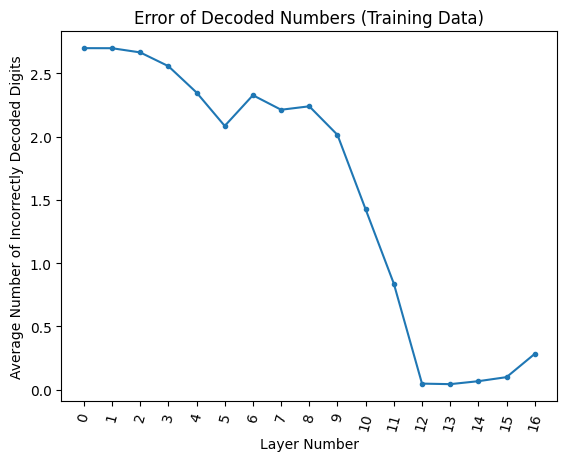

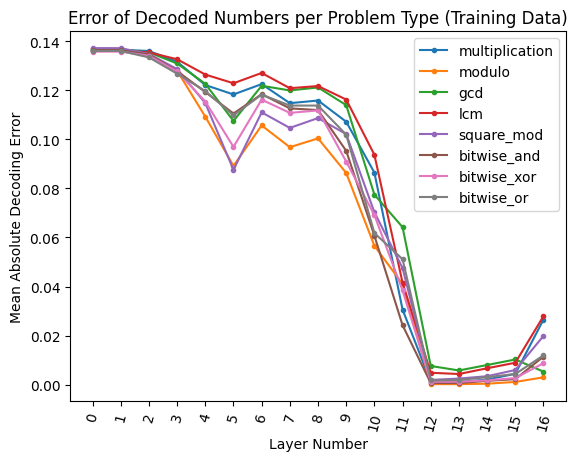

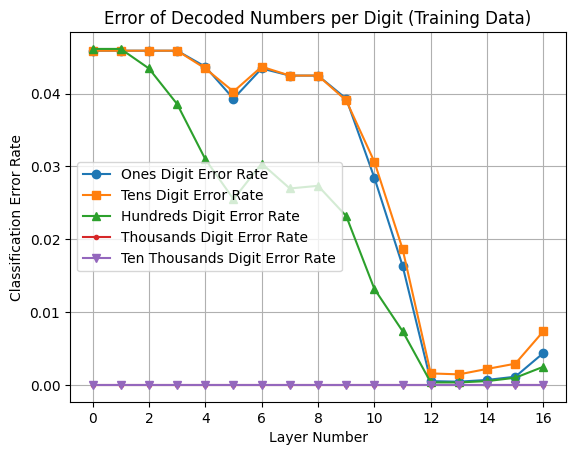

In [23]:
x_ticks = np.arange(layer_numbers.cpu()[0].item(), layer_numbers.cpu()[0].item() + len(layer_numbers), 1)
plt.plot(x_ticks, errors, marker=".")
plt.xticks(x_ticks, rotation=75)
plt.title("Error of Decoded Numbers (Training Data)")
plt.ylabel("Average Number of Incorrectly Decoded Digits")
plt.xlabel("Layer Number")
plt.grid(False)
if log_wandb:
    wandb.log({f"Error of Decoded Numbers (Training Data)": wandb.Image(plt)})
    wandb.log({f"Error Matrix (Training Data)": errors})
else:
    plt.show()
plt.close()

for pt in problem_type:
    x_ticks = np.arange(layer_numbers.cpu()[0].item(), layer_numbers.cpu()[0].item() + len(layer_numbers), 1)
    pt_error = [np.mean(errors_per_pt[pt][ln]) for ln in errors_per_pt[pt]]
    plt.plot(x_ticks, pt_error, marker=".")
    plt.xticks(x_ticks, rotation=75)
    #plt.close()
plt.title(f"Error of Decoded Numbers per Problem Type (Training Data)")
plt.ylabel("Mean Absolute Decoding Error")
plt.xlabel("Layer Number")
plt.legend(problem_type)
plt.grid(False)
if log_wandb:
    wandb.log({f"Error of Decoded Numbers per Problem Type (Training Data)": wandb.Image(plt)})
    wandb.log({f"Error per Problem Type (Training Data)": errors_per_pt})
else:
    plt.show()
plt.close()

labels = ['Ones Digit Error Rate',
        'Tens Digit Error Rate',
        'Hundreds Digit Error Rate',
        'Thousands Digit Error Rate',
        'Ten Thousands Digit Error Rate',
        'Hundred Thousands Digit Error Rate',
        'Millions Digit Error Rate',
        'Ten Millions Digit Error Rate',
        'Hundred Millions Digit Error Rate',
        ]
markers = ["o", "s", "^", 
        ".", "v", "*", 
        "<", ">", "1"]

for n, digit in enumerate(per_digit_errors.float().cpu().numpy().T):
    plt.plot(layer_numbers.cpu(), digit, label=labels[n], marker=markers[n])

plt.title(f"Error of Decoded Numbers per Digit (Training Data)")
plt.xlabel('Layer Number')
plt.ylabel('Classification Error Rate')
plt.legend()
plt.grid(True)
if log_wandb:
    wandb.log({f"Error of Decoded Numbers per Digit (Training Data)": wandb.Image(plt)})
    wandb.log({f"Error per Digit (Training Data)": per_digit_errors.float().cpu().numpy().T})
else:
    plt.show()
plt.close()


In [24]:
verbose = 0
testing_verbose = 0

In [25]:
def get_dialog_indices(generator, dialog, calculate_end_index=False):
    start_indices = []
    end_indices   = []
    for i in range(len(dialog)):
        # Find the final occurance of user chat (which is the question being asked to the LLM)
        start_index = len(generator.parse_chat(dialog)[i]) - generator.parse_chat(dialog)[i][::-1].index(882) + 2
        # The final token position to save
        if not calculate_end_index:
            end_index   = -1 # If end_index is -1, use all tokens up till the end, otherwise calculate based on eot token
        else:
            end_index   = len(generator.parse_chat(dialog)[i]) - generator.parse_chat(dialog)[i][::-1].index(128009) - 1
        start_indices += [start_index]
        end_indices   += [end_index]
        
    return start_indices, end_indices

def training_step(n_samples, generator, temperature=0, problem_type="addition", df_dialogs=None, inference_to_backprop_ratio=1, 
                  optimizer=None, criterion=None, complexity=2, losses_per_pt=None, scores_per_pt=None, verbose=False):

    all_logits = []
    all_corr  = []

    total_score = 0
    outputs = []
    all_correct_responses = []
    all_dialogs = []
    pts     = []

    if type(df_dialogs) == type(None):
        generate_random_dialog = True
    else:
        generate_random_dialog = False

        # If the length of the current batch is not equal to the number of samples the LLM will consume times the 
        #  inference_to_backprop_ratio, adjust the inference_to_backprop_ratio accordingly
        if len(df_dialogs) // n_samples != inference_to_backprop_ratio:
            inference_to_backprop_ratio = len(df_dialogs) // n_samples

        batch_question, batch_problem_type = df_dialogs["question"], df_dialogs["problem_type"]
        batch_x, batch_y, batch_solution   = df_dialogs["x"], df_dialogs["y"], df_dialogs["solution"]

        # batch_dialog_data is a list of lists, with length equal to the length of df_dialogs. Each list contains 4 items. The first is 
        #  the dialogs object, which is a list of Dialog objects, the length of which is equal to n_samples. The second is the x values, which is 
        #  an array of integers, the third is the y values (also array of integers), and the final is the problem type, a string
        batch_dialog_data = [generate_dialog(complexity=complexity, samples=1, string_nums=generator.model.test_with_non_numerical_rep,
                                             limit_solution_digits=generator.model.limit_solution_digits, modify_question_format=generator.model.modify_question_format,
                                             problem_type=pt) for pt in batch_problem_type]

        for d in range(n_samples):
            # First index is grabbing the batch item, second index is grabbing the dialog (instead of the x, y , pt),
            #  third index is grabbing the batch item within dialogs (which is always of length 1 due to samples=1 above), and last
            #  index is grabbing the last dialog sequence, since we only want to change that while leaving the example dialogs the same
            batch_dialog_data[d][0][0][-1]['content'] = batch_question.values[d]
            batch_dialog_data[d][1][0], batch_dialog_data[d][2][0] = batch_x.values[d], batch_y.values[d]


        # batch_dialog_data should be [dialog, x, y, pt], where each element is n_samples long. batch_dialog_data previously was of length n_samples, where each
        #  item in the sequence was [dialog, x, y, pt]. The below code puts it into the correct format
        batch_dialog_data = [[d[0][0] for d in batch_dialog_data],
                             np.array([d[1][0] for d in batch_dialog_data]),
                             np.array([d[2][0] for d in batch_dialog_data]),
                             batch_problem_type.values]
        
    for n in range(inference_to_backprop_ratio):
        if verbose:
            print("On sub-step iteration:", n+1)
        response_data = {}

        total_loss = 0

        if generate_random_dialog:
            dialogs, x, y, curr_problem_type = generate_dialog(complexity=complexity, samples=n_samples, problem_type=problem_type, 
                                                               limit_solution_digits=generator.model.limit_solution_digits, 
                                                               #modify_question_format=generator.model.modify_question_format # Don't train the decoder on the modified question formats
                                                               )
        else:
            micro_batch_dialog_data = [batch_dialog_data[0][(n) * n_samples : (n + 1) * n_samples], batch_dialog_data[1][(n) * n_samples : (n + 1) * n_samples], 
                                       batch_dialog_data[2][(n) * n_samples : (n + 1) * n_samples], batch_dialog_data[3][(n) * n_samples : (n + 1) * n_samples]]
            dialogs, x, y, curr_problem_type = micro_batch_dialog_data[0], micro_batch_dialog_data[1], micro_batch_dialog_data[2], micro_batch_dialog_data[3]
            curr_problem_type = curr_problem_type[0] # TODO: Fix this hack (by getting the forward pass to accept multiple different problem types). Current workaround is setting n_samples to 1
            #print("curr_dialogs:", dialogs, x, y, curr_problem_type)

        all_dialogs += [dialogs]
        if generator.model.encoder_input_tokens == "all":
            start_indices, end_indices    = get_dialog_indices(generator, dialogs, calculate_end_index=generator.model.calculate_end_index)
            generator.model.curr_start_indices = start_indices
            generator.model.curr_end_indices   = end_indices
            generator.model.dialogs            = dialogs

        #if generator.model.calculate_encoding_accuracy or generator.model.simulate_perfect_encoder or generator.model.record_score_per_problem:
        #    generator.model.curr_x  = x
        #    generator.model.curr_y  = y
        #    generator.model.curr_pt = curr_problem_type

        pts += [curr_problem_type]
        if curr_problem_type=="addition":
            correct_responses = [x[i] + y[i] for i in range(len(x))]
        elif curr_problem_type=="multiplication":
            if generator.model.limit_solution_digits:
                correct_responses = [(x[i] * y[i]) % 10**(complexity+1) for i in range(len(x))]
            else:
                correct_responses = [(x[i] * y[i]) for i in range(len(x))]
        elif curr_problem_type=="division":
            correct_responses = [int(x[i] // y[i]) for i in range(len(x))]
        elif curr_problem_type=="modulo":
            correct_responses = [x[i] % y[i] for i in range(len(x))]
        elif curr_problem_type=="gcd":
            correct_responses = [np.gcd(x[i], y[i]) for i in range(len(x))]
        elif curr_problem_type=="lcm":
            if generator.model.limit_solution_digits:
                correct_responses = [np.lcm(x[i], y[i]) % 10**(complexity+1) for i in range(len(x))]
            else:
                correct_responses = [np.lcm(x[i], y[i]) for i in range(len(x))]
        elif curr_problem_type=="square_mod":
            correct_responses = [x[i]**2 % y[i] for i in range(len(x))]
        elif curr_problem_type=="bitwise_and":
            correct_responses = [x[i] & y[i] for i in range(len(x))]
        elif curr_problem_type=="bitwise_xor":
            correct_responses = [x[i] ^ y[i] for i in range(len(x))]
        elif curr_problem_type=="bitwise_or":
            correct_responses = [x[i] | y[i] for i in range(len(x))]
        elif curr_problem_type=="bitwise_nand":
            correct_responses = [~(x[i] & y[i]) for i in range(len(x))]
        elif curr_problem_type=="bitwise_nxor":
            correct_responses = [~(x[i] ^ y[i]) for i in range(len(x))]
        elif curr_problem_type=="bitwise_nor":
            correct_responses = [~(x[i] | y[i]) for i in range(len(x))]
        else:
            print("Unrecognized problem type:", curr_problem_type)
        

        all_correct_responses += correct_responses

        # Shape of list_of_probs and list_of_logits is (sequence_output_length, batch_size, num_tokens)
        h_stack, list_of_probs, list_of_logits, out_tokens = episode(dialogs=dialogs, generator=generator, temperature=temperature,
                                                                     inference_mode=generator.model.forward_symbolic_funnel, max_decoding_length=complexity+5, 
                                                                     curr_pt=curr_problem_type, curr_x=x, curr_y=y, verbose=verbose)

        #print(list_of_logits.shape, list_of_probs.shape)

        all_logits = all_logits + [list_of_logits]
        all_corr   = all_corr   + [torch.tensor(correct_responses)]

        for i in range(len(out_tokens)): # Iterate over n_samples
            try:
                output = int(generator.tokenizer.decode(out_tokens[i]))
                score  = int(output == correct_responses[i])
            except Exception as e:
                if verbose:
                    print("!! Can't convert to int !!:", e)
                output = generator.tokenizer.decode(out_tokens[i])
                score = 0
            total_score += score
            if type(problem_type) == list:
                scores_per_pt[curr_problem_type] += [score]
            outputs += [output]
            if verbose == 2 or (verbose and i == 0):
                print("Actual values:                        ",
                      "first number:", x[i], "second number:", y[i], 
                      curr_problem_type + ":", correct_responses[i],
                      "LLM response:", output, "score:", score)


    max_len = max(t.size(0) for t in all_logits)
    padded_tensors = []
    for t in all_logits:
        #print("T_SHAPE:", t.shape, len(all_logits))
        T, B, V = t.shape
        pad_amount = max_len - T
        t_padded = F.pad(t, (0, 0, 0, 0, 0, pad_amount), value=0)
        padded_tensors.append(t_padded)

    all_logits = torch.cat(padded_tensors, dim=1)
    all_corr   = torch.concat(all_corr)

    optimizer.zero_grad()

    stop_token = generator.tokenizer.special_tokens["<|eot_id|>"]

    loss = 0
    losses = []
    for batch in range(len(all_corr)):
        correct_tokens = torch.tensor(generator.tokenizer.encode(str(all_corr[batch].item()), bos=False, eos=False))
        correct_tokens = torch.cat([correct_tokens, torch.tensor([stop_token])])
        correct_sequence_length  = len(correct_tokens)
        response_sequence_length = all_logits[:,batch,:].shape[0]
        sequence_length = min(correct_sequence_length, response_sequence_length)
        batch_loss = criterion(all_logits[:sequence_length,batch,:], correct_tokens[:sequence_length])
        loss += batch_loss
        losses += [batch_loss.detach().cpu().item()]
        losses_per_pt[pts[batch//n_samples]] += [batch_loss.detach().cpu().float()]
        if log_wandb:
            wandb.log({
                f"step_{pts[batch//n_samples]}": len(losses_per_pt[pts[batch//n_samples]])-1,
                f"loss_{ pts[batch//n_samples]}": losses_per_pt[pts[batch//n_samples]][-1],
                f"score_{pts[batch//n_samples]}": scores_per_pt[pts[batch//n_samples]][-1],
            })

    loss = loss / len(all_corr)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    total_score = total_score / len(all_corr)

    if verbose:
        tn = 0
        for p in generator.model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                tn += param_norm.item() ** 2
        total_norm = (tn ** 0.5) / len(dialogs) # normalize by batch size
        print(f"Total gradient norm after clipping: {total_norm}")

    response_data = {
        "Model Guesses": outputs,
        "Correct Answer": all_correct_responses,
        "Losses": losses,
        "All Dialogs": dialogs,
    }


    return total_loss, total_score, response_data

def inference_step(n_samples, generator, temperature=0, problem_type="addition", df_dialogs=None, 
                   inference_to_backprop_ratio=1, criterion=None, cot=False, complexity=2, verbose=False):

    all_logits = []
    all_corr  = []

    total_score = 0
    outputs = []
    pts     = []

    if type(df_dialogs) == type(None):
        generate_random_dialog = True
    else:
        #print("df_dialogs shape:", df_dialogs.shape)
        generate_random_dialog = False

        # If the length of the current batch is not equal to the number of samples the LLM will consume times the 
        #  inference_to_backprop_ratio, adjust the inference_to_backprop_ratio accordingly
        if len(df_dialogs) // n_samples != inference_to_backprop_ratio:
            inference_to_backprop_ratio = len(df_dialogs) // n_samples
        batch_question, batch_problem_type = df_dialogs["question"], df_dialogs["problem_type"]
        batch_x, batch_y, batch_solution   = df_dialogs["x"], df_dialogs["y"], df_dialogs["solution"]

        # batch_dialog_data is a list of lists, with length equal to the length of df_dialogs. Each list contains 4 items. The first is 
        #  the dialogs object, which is a list of Dialog objects, the length of which is equal to n_samples. The second is the x values, which is 
        #  an array of integers, the third is the y values (also array of integers), and the final is the problem type, a string
        batch_dialog_data = [generate_dialog(complexity=complexity, samples=1, string_nums=generator.model.test_with_non_numerical_rep, cot=cot,
                                             limit_solution_digits=generator.model.limit_solution_digits, modify_question_format=generator.model.modify_question_format,
                                             problem_type=pt) for pt in batch_problem_type]

        for d in range(n_samples):
            # First index is grabbing the batch item, second index is grabbing the dialog (instead of the x, y , pt),
            #  third index is grabbing the batch item within dialogs (which is always of length 1 due to samples=1 above), and last
            #  index is grabbing the last dialog sequence, since we only want to change that while leaving the example dialogs the same
            if cot:
                batch_dialog_data[d][0][0][-1]['content'] = f"Solve the following problem step by step: " + batch_question.values[d]
            else:
                batch_dialog_data[d][0][0][-1]['content'] = batch_question.values[d]
            batch_dialog_data[d][1][0], batch_dialog_data[d][2][0] = batch_x.values[d], batch_y.values[d]


        # batch_dialog_data should be [dialog, x, y, pt], where each element is n_samples long. batch_dialog_data previously was of length n_samples, where each
        #  item in the sequence was [dialog, x, y, pt]. The below code puts it into the correct format
        batch_dialog_data = [[d[0][0] for d in batch_dialog_data],
                             np.array([d[1][0] for d in batch_dialog_data]),
                             np.array([d[2][0] for d in batch_dialog_data]),
                             batch_problem_type.values]

    for n in range(inference_to_backprop_ratio):
        if verbose:
            print("On sub-step iteration:", n+1)
        response_data = []

        total_loss = 0

        if generator.model.test_on_unrelated_questions:
            dialogs, correct_responses, curr_problem_type = generate_non_math_dialog(samples=n_samples, topic="random", cot=cot)
            x, y = 0, 0 # Placeholder values
        else:            
            if generate_random_dialog:
                dialogs, x, y, curr_problem_type = generate_dialog(complexity=complexity, samples=n_samples, problem_type=problem_type, string_nums=generator.model.test_with_non_numerical_rep,
                                                                   limit_solution_digits=generator.model.limit_solution_digits, modify_question_format=generator.model.modify_question_format, cot=cot)
            else:
                micro_batch_dialog_data = [batch_dialog_data[0][(n) * n_samples : (n + 1) * n_samples], batch_dialog_data[1][(n) * n_samples : (n + 1) * n_samples], 
                                           batch_dialog_data[2][(n) * n_samples : (n + 1) * n_samples], batch_dialog_data[3][(n) * n_samples : (n + 1) * n_samples]]
                dialogs, x, y, curr_problem_type = micro_batch_dialog_data[0], micro_batch_dialog_data[1], micro_batch_dialog_data[2], micro_batch_dialog_data[3]
                curr_problem_type = curr_problem_type[0] # TODO: Fix this hack (by getting the forward pass to accept multiple different problem types). Current workaround is setting n_samples to 1

            if generator.model.encoder_input_tokens == "all":
                start_indices, end_indices    = get_dialog_indices(generator, dialogs, calculate_end_index=generator.model.calculate_end_index)
                generator.model.curr_start_indices = start_indices
                generator.model.curr_end_indices   = end_indices
                generator.model.dialogs            = dialogs


        if generator.model.test_with_non_numerical_rep:
            conv = lambda x: w2n.word_to_num(str(x))
            conv_inv = lambda x: x
            #conv_inv = lambda x: n2w.num2words(int(x)) # Uncomment this if you want the correct response to be numerical rather than words

        else:
            conv = lambda x: x
            conv_inv = lambda x: x

        #if generator.model.calculate_encoding_accuracy or generator.model.simulate_perfect_encoder or generator.model.record_score_per_problem:
        #    generator.model.curr_x  = x
        #    generator.model.curr_y  = y
        #    generator.model.curr_pt = curr_problem_type


        pts += [curr_problem_type]
        if curr_problem_type=="addition":
            correct_responses = [conv_inv(conv(x[i]) + conv(y[i])) for i in range(len(x))]
        if curr_problem_type=="multiplication":
            if generator.model.limit_solution_digits:
                correct_responses = [conv_inv((conv(x[i]) * conv(y[i])) % 10**(complexity+1)) for i in range(len(x))]
            else:
                correct_responses = [conv_inv((conv(x[i]) * conv(y[i]))) for i in range(len(x))]
        if curr_problem_type=="division":
            correct_responses = [conv_inv(int(conv(x[i]) // conv(y[i]))) for i in range(len(x))]
        if curr_problem_type=="modulo":
            correct_responses = [conv_inv(conv(x[i]) % conv(y[i])) for i in range(len(x))]
        if curr_problem_type=="gcd":
            correct_responses = [conv_inv(np.gcd(conv(x[i]), conv(y[i]))) for i in range(len(x))]
        if curr_problem_type=="lcm":
            if generator.model.limit_solution_digits:
                correct_responses = [conv_inv(np.lcm(conv(x[i]), conv(y[i])) % 10**(complexity+1)) for i in range(len(x))]
            else:
                correct_responses = [conv_inv(np.lcm(conv(x[i]), conv(y[i]))) for i in range(len(x))]
        if curr_problem_type=="square_mod":
            correct_responses = [conv_inv(conv(x[i])**2 % conv(y[i])) for i in range(len(x))]
        if curr_problem_type=="bitwise_and":
            correct_responses = [conv_inv(conv(x[i]) & conv(y[i])) for i in range(len(x))]
        if curr_problem_type=="bitwise_xor":
            correct_responses = [conv_inv(conv(x[i]) ^ conv(y[i])) for i in range(len(x))]
        if curr_problem_type=="bitwise_or":
            correct_responses = [conv_inv(conv(x[i]) | conv(y[i])) for i in range(len(x))]
        if curr_problem_type=="bitwise_nand":
            correct_responses = [conv_inv(~(conv(x[i]) & conv(y[i]))) for i in range(len(x))]
        if curr_problem_type=="bitwise_nxor":
            correct_responses = [conv_inv(~(conv(x[i]) ^ conv(y[i]))) for i in range(len(x))]
        if curr_problem_type=="bitwise_nor":
            correct_responses = [conv_inv(~(conv(x[i]) | conv(y[i]))) for i in range(len(x))]
            

        # if using cot or querying with full word numerical representations, set the max decoding length to a large value, otherwise set it to a small value
        if cot or generator.model.test_with_non_numerical_rep:
            mdl = min(1000, max_seq_len)
        else:
            mdl = complexity+5

        # Shape of list_of_probs and list_of_logits is (sequence_output_length, batch_size, num_tokens)
        h_stack, list_of_probs, list_of_logits, out_tokens = episode(generator=generator, dialogs=dialogs, temperature=temperature,
                                                                     inference_mode=generator.model.forward_symbolic_funnel, max_decoding_length=mdl, 
                                                                     curr_pt=curr_problem_type, curr_x=x, curr_y=y, verbose=verbose)

        if cot and not generator.model.test_on_unrelated_questions:
            token_for_final = 19918
            bold_token = 334 # Sometimes llama outputs Final Answer in bold markdown (** symbol)
            modified_list_of_logits = []
            modified_out_tokens     = []
            modified_list_of_probs  = []
            for i in range(len(out_tokens)):
                if token_for_final not in out_tokens[i]: # 19918 is the token for the word "Final":
                    if verbose == 1 and i == 0:
                        print("COT response does not contain the phrase 'Final Answer:' as required:\n", 
                              generator.tokenizer.decode(out_tokens[i]))
                    elif verbose == 2:
                        print("COT response does not contain the phrase 'Final Answer:' as required:\n", 
                              generator.tokenizer.decode(out_tokens[i]))
                    modified_out_tokens     += [out_tokens[i]]
                    modified_list_of_logits += [list_of_logits[:,i,:]]
                    modified_list_of_probs  += [list_of_probs [:,i,:]]
                else:
                    if verbose == 1 and i == 0:
                        print("COT response:\n", 
                              generator.tokenizer.decode(out_tokens[i]))
                    if verbose == 2:
                        print("COT response:\n", 
                              generator.tokenizer.decode(out_tokens[i]))
                    # The phrase "Final Answer: " should be 4 tokens long, so we skip that many tokens to get the answer
                    if bold_token in out_tokens[i][(out_tokens[i].index(token_for_final) + 4):   ]:
                        fp = (out_tokens[i][(out_tokens[i].index(token_for_final) + 4):].index(bold_token) + 
                              out_tokens[i].index(token_for_final) + 4)
                        modified_out_tokens     += [out_tokens    [  i  ][(out_tokens[i].index(token_for_final) + 4):fp   ]]
                        modified_list_of_logits += [list_of_logits[:,i,:][(out_tokens[i].index(token_for_final) + 4):fp,:,]]
                        modified_list_of_probs  += [list_of_probs [:,i,:][(out_tokens[i].index(token_for_final) + 4):fp,:,]]
                    else:
                        modified_out_tokens     += [out_tokens    [  i  ][(out_tokens[i].index(token_for_final) + 4):   ]]
                        modified_list_of_logits += [list_of_logits[:,i,:][(out_tokens[i].index(token_for_final) + 4):,:,]]
                        modified_list_of_probs  += [list_of_probs [:,i,:][(out_tokens[i].index(token_for_final) + 4):,:,]]

            list_of_logits = torch.cat(modified_list_of_logits, axis=1)
            list_of_probs  = torch.cat(modified_list_of_probs,  axis=1)
            out_tokens     = modified_out_tokens

        elif generator.model.test_on_unrelated_questions:
            for i in range(len(out_tokens)):
                output = generator.tokenizer.decode(out_tokens[i])

                if verbose == 1 and i == 0:
                    print("COT response on non math problems:\n", output)
                if verbose == 2:
                    print("COT response on non math problems:\n", output)

                response_data += ["Model Guesses:", output]
                response_data += ["Correct Answer:", correct_responses[i]]
                
            return 0, 0, response_data



        all_logits = all_logits + [list_of_logits]
        all_corr   = all_corr   + [torch.tensor(correct_responses)]

        for i in range(len(out_tokens)): # Iterate over n_samples
            try:
                output = int(generator.tokenizer.decode(out_tokens[i]))
                score  = int(output == correct_responses[i])
            except Exception as e:
                if verbose == 1 and i == 0:
                    print("!! Can't convert to int !!:", e)
                elif verbose == 2:
                    print("!! Can't convert to int !!:", e)
                output = generator.tokenizer.decode(out_tokens[i])
                score = 0
            total_score += score
            outputs += [output]
            if verbose == 2 or (verbose and i == 0):
                print("Actual values:             ",
                      "first number:", x[i], "second number:", y[i], 
                      curr_problem_type + ":", correct_responses[i],
                      "LLM response:", output, "score:", score)

            response_data += ["Model Guesses:", output]
            response_data += ["Correct Answer:", correct_responses[i]]

    max_len = max(t.size(0) for t in all_logits)
    padded_tensors = []
    for t in all_logits:
        T, B, V = t.shape
        pad_amount = max_len - T
        t_padded = F.pad(t, (0, 0, 0, 0, 0, pad_amount), value=0)
        padded_tensors.append(t_padded)

    all_logits = torch.cat(padded_tensors, dim=1)
    all_corr   = torch.concat(all_corr)

    loss = 0
    for batch in range(len(all_corr)):
        correct_tokens = torch.tensor(generator.tokenizer.encode(str(all_corr[batch].item()), bos=False, eos=False))
        correct_sequence_length  = len(correct_tokens)
        response_sequence_length = all_logits[:,batch,:].shape[0]
        sequence_length = min(correct_sequence_length, response_sequence_length)
        batch_loss = criterion(all_logits[:sequence_length,batch,:], correct_tokens[:sequence_length])
        loss += batch_loss
    loss = loss / len(all_corr)

    total_loss += loss.item()

    total_score = total_score / len(all_corr)

    return total_loss, total_score, response_data

def evaluate_model(testing_n_samples, testing_num_steps, testing_temperature, problem_type, generator, criterion=None, 
                   inference_to_backprop_ratio=1, complexity=2, cot=False, df=None, testing_steps_to_print=10, testing_verbose=0):
    losses    = []
    scores    = []
    responses = []
    generator.model.eval()
    with torch.no_grad():
        for step in range(testing_num_steps):
            if type(df) != type(None):
                df_dialogs = df.iloc[step * (testing_n_samples * inference_to_backprop_ratio): (step + 1) * (testing_n_samples * inference_to_backprop_ratio)]
            else:
                df_dialogs = None

            loss, score, response_data = inference_step(n_samples=testing_n_samples, generator=generator,
                                                        temperature=testing_temperature, problem_type=problem_type, 
                                                        inference_to_backprop_ratio=inference_to_backprop_ratio, 
                                                        criterion=criterion, cot=cot, complexity=complexity, 
                                                        df_dialogs=df_dialogs, verbose=testing_verbose)
            losses += [loss]
            scores += [score]
            responses += [response_data]
            if testing_steps_to_print and testing_num_steps // testing_steps_to_print and not step % (testing_num_steps // testing_steps_to_print):
                print(f" -------------- Step {step}, Loss: {loss}, Score: {score}  -------------- ")

    return losses, scores, responses

def plot_results(losses, scores, problem_type, bypass_symbolic):
    losses = np.array(losses)
    scores = np.array(scores)

    if bypass_symbolic == 1:
        output_text = f"Mean score and loss of standard LLM on {problem_type}: " + str(round(scores.mean()*100, 3)) + " ± " + str(round(scores.std()*100, 4)) + ", " + str(round(losses.mean(), 3)) + " ± " + str(round(losses.std(), 4))
    else:
        output_text = f"Mean score and loss of symbolic LLM on {problem_type}: " + str(round(scores.mean()*100, 3)) + " ± " + str(round(scores.std()*100, 4)) + ", " + str(round(losses.mean(), 3)) + " ± " + str(round(losses.std(), 4))
    print(f"\n", output_text)
    return output_text

def create_smooth_data(curve, n=3, starting_index=10):
    data = curve[starting_index:]
    smoothed_list = []
    length = len(data)
    for i in range(length):
        # Determine the range of indices to average
        start = max(0, i - n)
        end = min(length, i + n + 1)
        # Calculate the average of the surrounding elements
        smoothed_list.append(sum(data[start:end]) / (end - start))
    return smoothed_list



In [26]:
if "post_fine_tuning" in decoder_path:
    print(f"Changing the value of initialize_decoders from {initialize_decoders} to False due to 'post_fine_tuning' being in the decoder_path")
    initialize_decoders = False

if test_baseline == 2:
    print(f"Changing the value of train_model from {train_model} to False due to test_baseline = {test_baseline}")
    print(f"Changing the value of validate_model from {validate_model} to False due to test_baseline = {test_baseline}")
    train_model = False
    validate_model = False

if cot == True:
    print(f"Changing the value of test_baseline from {test_baseline} to 2 due to cot = {cot}")
    print(f"Changing the value of train_model from {train_model} to False due to cot = {cot}")
    print(f"Changing the value of validate_model from {validate_model} to False due to cot = {cot}")
    print(f"Changing the value of calculate_encoding_accuracy from {calculate_encoding_accuracy} to False due to cot = {cot}")
    print(f"Changing the value of record_score_per_problem from {record_score_per_problem} to 0 due to cot = {cot}")
    test_baseline = 2
    train_model = False
    validate_model = False
    calculate_encoding_accuracy = False
    record_score_per_problem = 0

if test_on_unrelated_questions == True:
    print(f"Changing the value of cot from {cot} to True due to test_on_unrelated_questions = {test_on_unrelated_questions}")
    print(f"Changing testing_problems to non-math related subjects due to test_on_unrelated_questions = {test_on_unrelated_questions}")
    print(f"Changing the value of test_baseline from {test_baseline} to True due to test_on_unrelated_questions = {test_on_unrelated_questions}")
    print(f"Changing the value of calculate_encoding_accuracy from {calculate_encoding_accuracy} to False due to test_on_unrelated_questions = {test_on_unrelated_questions}")
    print(f"Changing testing_data_df_path to "" due to test_on_unrelated_questions = {test_on_unrelated_questions}")
    print(f"Changing the value of record_score_per_problem from {record_score_per_problem} to 2 due to test_model = {test_model}")
    cot = True
    testing_problems = ['philosophy', 'ethics', 'history', 'psychology', 'science_fiction', 'technology', 'art_and_culture']
    test_baseline = 1
    calculate_encoding_accuracy = False
    #training_data_df_path = ""
    #val_data_df_path = ""
    testing_data_df_path = ""
    record_score_per_problem = 3

if not test_model:
    if record_score_per_problem:
        print(f"Changing the value of record_score_per_problem from {record_score_per_problem} to 1 due to test_model = {test_model}")
        record_score_per_problem = 1


if type(problem_type) == list:
    losses_per_pt = {pt: [] for pt in problem_type}
    scores_per_pt = {pt: [] for pt in problem_type}

criterion = nn.CrossEntropyLoss()

if log_wandb:
    save_path  = decoder_path.split("/")[-1].split(".pth")[0] + f"_post_fine_tuning_{wandb.run.id if log_wandb else run_name}_"
else:
    save_path  = decoder_path.split("/")[-1].split(".pth")[0] + f"_post_fine_tuning_"


if record_score_per_problem or calculate_encoding_accuracy:
    if not os.path.exists(f"{curr_dir}/outputs"):
        os.mkdir(f"{curr_dir}/outputs")

if record_score_per_problem == 1:
    with open(f"{curr_dir}/outputs/score_per_problem_training_{wandb.run.id if log_wandb else run_name}.txt", "w") as file:
        file.write("split,actual_problem_type,predicted_problem_type,score\n")
if record_score_per_problem == 2:
    with open(f"{curr_dir}/outputs/score_per_problem_testing_{wandb.run.id if log_wandb else run_name}.txt", "w") as file:
        file.write("split,actual_problem_type,predicted_problem_type,score\n")
if record_score_per_problem == 3:
    with open(f"{curr_dir}/outputs/score_per_problem_training_and_testing_{wandb.run.id if log_wandb else run_name}.txt", "w") as file:
        file.write("split,actual_problem_type,predicted_problem_type,score\n")


In [27]:
#################################################################################
############################## Model preprocessing ##############################
#################################################################################


if not initialize_lora:
    generator.model.encoders = torch.load(encoder_path, weights_only=False) 
    generator.model.decoders = torch.load(decoder_path, weights_only=False)

if lora_baseline:
    lora_encoders = nn.ModuleList()
    lora_decoders = nn.ModuleList()
    # If generator.model.encoders is not None, initialize them as random networks
    if not initialize_lora:
        for layer_id in torch.stack([generator.model.encoders[i].layer_id for i in range(len(generator.model.encoders))]):
            # Assume that linear encoder and decoder networks are used
            lora_encoder = Encoder(layer_id, generator.model.output.weight.shape[1], generator.model.SE.VSA_dim).to(device)
            lora_decoder = Decoder(layer_id, generator.model.SE.VSA_dim, generator.model.output.weight.shape[1]).to(device)
            lora_encoders.append(lora_encoder)
            lora_decoders.append(lora_decoder)

        generator.model.encoders = lora_encoders
        generator.model.decoders = lora_decoders

    # initialize_decoders = False
    # rms_layer = True

if initialize_lora:
    generator.model.encoders = torch.load(encoder_path, weights_only=False)
    generator.model.decoders = torch.load(decoder_path, weights_only=False)

generator.model.wandb_run_id                = wandb.run.id if log_wandb else run_name

generator.model.bypass_symbolic             = False
generator.model.add_noise                   = False

generator.model.curr_dir                    = curr_dir
generator.model.problem_type                = problem_type
generator.model.symbolic_encoding_layer     = symbolic_encoding_layer
generator.model.symbolic_decoding_layers    = symbolic_decoding_layers
generator.model.normalize_vector            = normalize_vector
generator.model.rms_layer                   = rms_layer
generator.model.single_number_generation    = single_number_generation
generator.model.complexity                  = complexity

generator.model.lora_baseline               = lora_baseline

generator.model.problem_score_threshold     = problem_score_threshold
generator.model.training_problems           = problem_type
generator.model.record_score_per_problem    = record_score_per_problem
generator.model.normalize_VSA_before_dot    = normalize_VSA_before_dot
generator.model.use_specific_identities     = use_specific_identities
generator.model.test_on_unrelated_questions = test_on_unrelated_questions
generator.model.test_with_non_numerical_rep = test_with_non_numerical_rep

generator.model.encoder_input_tokens        = encoder_input_tokens
generator.model.calculate_end_index         = calculate_end_index

generator.model.multi_token_intervention    = multi_token_intervention
generator.model.static_encoding             = static_encoding
generator.model.calculate_encoding_accuracy = calculate_encoding_accuracy
generator.model.encode_counter              = encode_counter

generator.model.limit_solution_digits       = limit_solution_digits
generator.model.simulate_perfect_encoder    = simulate_perfect_encoder
generator.model.modify_question_format      = modify_question_format

if generator.model.calculate_encoding_accuracy:
    # During training, calculate accuracy per problem type, per digit, per input number
    generator.model.encoding_accuracy = {}
    for pt in generator.model.SE.possible_problems:
        generator.model.encoding_accuracy[pt] = {}
        for digit in range(complexity + 1):
            generator.model.encoding_accuracy[pt]["digit " + str(digit)] = {}
            generator.model.encoding_accuracy[pt]["digit " + str(digit)]["first_number"]  = []
            generator.model.encoding_accuracy[pt]["digit " + str(digit)]["second_number"] = []


starting_encoder_layer = 0
for i in range(len(generator.model.encoders)):
    if (generator.model.encoders[i]) != type(None):
        starting_encoder_layer = i
        break

starting_decoder_layer = 0
for i in range(len(generator.model.decoders)):
    if (generator.model.decoders[i]) != type(None):
        starting_decoder_layer = i
        break

generator.model.starting_encoder_layer = starting_encoder_layer
generator.model.starting_decoder_layer = starting_decoder_layer

generator.model.encoders.eval()

if rms_layer:
    generator.model.rms_layers = [] 
    for sl in symbolic_decoding_layers:
        if sl != 33:
            generator.model.rms_layers.append(RMSNorm(generator.model.output.weight.shape[1], eps=1e-05)) # params.dim, eps=params.norm_eps
        else:
            generator.model.rms_layers.append(RMSNorm(generator.model.output.weight.shape[0], eps=1e-05)) # num_tokens, eps=params.norm_eps
else:
    generator.model.skip_weights = nn.Parameter(torch.zeros(len(symbolic_decoding_layers)) + starting_skip_strength)

if initialize_decoders:
    pseudo_inverses = {}
    for sl in symbolic_decoding_layers:
        for p in generator.model.encoders[sl-generator.model.starting_decoder_layer].parameters():
            pseudo_inverses[sl-generator.model.starting_decoder_layer] = torch.linalg.pinv(p.float()).to(torch.bfloat16)

    for sl in symbolic_decoding_layers:
        for p in generator.model.decoders[sl-generator.model.starting_decoder_layer].parameters():
            p = pseudo_inverses[sl-generator.model.starting_decoder_layer]


if 33 in symbolic_decoding_layers:
    generator.model.decoders.append(ColumnParallelLinear(
        generator.model.SE.VSA_dim, generator.model.output.weight.shape[0], bias=False, init_method=lambda x: x
    ))
    print("Created 33rd decoder network")

# Delete unnecessary layers to save memory
for i in range(len(generator.model.decoders)):
    if i not in symbolic_decoding_layers:
        del generator.model.decoders[i]  # Delete layer
        generator.model.decoders.insert(i, None)  # Insert None to maintain indexing

for i in range(len(generator.model.encoders)):
    if i != symbolic_encoding_layer:
        del generator.model.encoders[i]  # Delete layer
        generator.model.encoders.insert(i, None)  # Insert None to maintain indexing


def safe_pickle_dump(obj, path):
    tmp_path = path + ".tmp"
    with open(tmp_path, "wb") as f:
        pickle.dump(obj, f)
    os.replace(tmp_path, path)

In [28]:
#####################################################################
############################# Training ##############################
#####################################################################


if train_model:
    responses = {}

    for param in generator.model.parameters():
        param.requires_grad = False
    for sl in symbolic_decoding_layers:
        for param in generator.model.decoders[sl-generator.model.starting_decoder_layer].parameters():
            param.requires_grad = True
    if lora_baseline:
        for param in generator.model.encoders[symbolic_encoding_layer-generator.model.starting_encoder_layer].parameters():
            param.requires_grad=True
    if rms_layer:
        for r_layer in generator.model.rms_layers:
            for param in r_layer.parameters():
                param.requires_grad = True


    if not rms_layer:
        generator.model.skip_weights.requires_grad = trainable_skip

    # Training loop

    params = list(filter(lambda p: p.requires_grad, generator.model.parameters()))
    print("Number of trainable parameters:", sum(p.numel() for p in params))

    if not training_data_df_path:
        use_existing_questions = False
    else:
        use_existing_questions = True
        train_questions_df = pd.read_csv(training_data_df_path)
        new_num_steps = math.ceil(len(train_questions_df) / (n_samples * inference_to_backprop_ratio)) # Change the number of steps so that the entire df is used once
        print(f"Training dataframe with {len(train_questions_df)} rows detected, changing the number of steps from {num_steps} to {new_num_steps}")

        num_steps = new_num_steps

        # TODO: Temporary hack fix to set the number of sampes (n_samples) fed into the LLM to 1. This won't change performance, but forces the batch_size fed into the LLM to be 1
        inference_to_backprop_ratio *= n_samples
        n_samples = 1

    if val_data_df_path:
        val_questions_df = pd.read_csv(val_data_df_path)
        new_num_steps = math.ceil(len(val_questions_df) / (val_n_samples * val_inference_to_backprop_ratio)) # Change the number of steps so that the entire df is used once
        print(f"Validation dataframe with {len(val_questions_df)} rows detected, changing the number of steps from {val_num_steps} to {new_num_steps}")

        val_num_steps = new_num_steps

        # TODO: Temporary hack fix to set the number of sampes (n_samples) fed into the LLM to 1. This won't change performance, but forces the batch_size fed into the LLM to be 1
        val_inference_to_backprop_ratio *= val_n_samples
        val_n_samples = 1
    else:
        val_questions_df = None


    optimizer = optim.Adam(filter(lambda p: p.requires_grad, generator.model.parameters()), lr=learning_rate)

    losses = []
    scores = []
    val_losses = []
    val_scores = []
    for epoch in range(num_epochs):
        generator.model.current_split = "train"


        print("On epoch:", epoch + 1)
        for step in range(num_steps):
            generator.model.train()

            if step + num_steps * epoch in learning_rate_reduction_factors.keys():
                for param_group in optimizer.param_groups:
                    param_group['lr'] = param_group['lr'] * learning_rate_reduction_factors[step + num_steps * epoch]  # Set new learning rate
                    print("Learning Rate changed to:", param_group['lr'])

            if use_existing_questions:
                df_dialogs = train_questions_df.iloc[step * (n_samples * inference_to_backprop_ratio): (step + 1) * (n_samples * inference_to_backprop_ratio)]
            else:
                df_dialogs = None

            loss, score, response_data = training_step(n_samples, generator, temperature=temperature, problem_type=problem_type, df_dialogs=df_dialogs,
                                                       inference_to_backprop_ratio=inference_to_backprop_ratio, optimizer=optimizer, criterion=criterion,
                                                       complexity=complexity, losses_per_pt=losses_per_pt, scores_per_pt=scores_per_pt, verbose=verbose)

            responses[step + num_steps * epoch] = response_data

            if save_responses:
                if not responses:
                    print("Warning: responses dict is empty — nothing to save!")
                else:
                    safe_pickle_dump(responses, f"outputs/responses_{wandb.run.id if log_wandb else run_name}.pkl")

            losses += [loss]
            scores += [score]

            if log_wandb:
                wandb.log({
                    "step": step + num_steps * epoch,
                    "loss":  loss,
                    "score": score
                })

            if not rms_layer:
                for n, sw in enumerate(generator.model.skip_weights.detach().cpu().float().numpy()):
                    if log_wandb:
                        wandb.log({f"skip_weights_{n}": sw})

            if steps_to_print and num_steps // steps_to_print and not (step + num_steps * epoch) % (num_steps // steps_to_print):
                if num_steps // steps_to_print >= 10:
                    if not rms_layer and trainable_skip:
                        print(f" -------------- Step {(step + num_steps * epoch)}, Loss: {np.mean(losses)}, Score: {np.mean(scores)}, Skip Weight: {generator.model.skip_weights.detach().cpu().float().numpy()}  -------------- ", flush=True)
                    else:
                        print(f" -------------- Step {(step + num_steps * epoch)}, Loss: {np.mean(losses)}, Score: {np.mean(scores)}  -------------- ", flush=True)
                else:
                    if not rms_layer and trainable_skip:
                        print(f" -------------- Step {(step + num_steps * epoch)}, Loss: {loss}, Score: {score}, Skip Weight: {generator.model.skip_weights.detach().cpu().float().numpy()}  -------------- ", flush=True)
                    else:
                        print(f" -------------- Step {(step + num_steps * epoch)}, Loss: {loss}, Score: {score}  -------------- ", flush=True)

            if (step + num_steps * epoch) and not (step + num_steps * epoch) % print_all_pts_freq:
                print("~~~~~~~~~~~~~ Printing Stats Per Problem Type: ~~~~~~~~~~~~~")
                for pt in losses_per_pt:
                    if len(losses_per_pt[pt]):
                        print("    Problem type:", pt)
                        print("    Loss:", np.mean(losses_per_pt[pt]), ", Score:", np.mean(scores_per_pt[pt]))

        if log_wandb:
            wandb.log({
                "epoch": epoch,
                "mean_train_loss":  np.mean(losses),
                "mean_train_score": np.mean(scores)
            })

        if validate_model:
            generator.model.current_split = "validation"
            val_loss, val_score, response_data  = evaluate_model(testing_n_samples=val_n_samples,
                                                                 testing_num_steps=val_num_steps,
                                                                 testing_temperature=val_temperature,
                                                                 problem_type=pt, generator=generator, criterion=criterion,
                                                                 inference_to_backprop_ratio=val_inference_to_backprop_ratio,
                                                                 complexity=complexity, cot=cot, df=val_questions_df,
                                                                 testing_steps_to_print=val_steps_to_print, testing_verbose=val_verbose)

            val_losses = [val_loss]
            val_scores = [val_score]

            if log_wandb:
                wandb.log({
                    "mean_val_loss":  np.mean(val_losses),
                    "mean_val_score": np.mean(val_scores)
                })



Number of trainable parameters: 2097152
On epoch: 1
 -------------- Step 0, Loss: 5.8125, Score: 0.0  -------------- 
Learning Rate changed to: 0.0005
 -------------- Step 100, Loss: 2.461140547648515, Score: 0.2202970297029703  -------------- 
~~~~~~~~~~~~~ Printing Stats Per Problem Type: ~~~~~~~~~~~~~
    Problem type: multiplication
    Loss: 2.599173 , Score: 0.1276595744680851
    Problem type: modulo
    Loss: 1.9870126 , Score: 0.23214285714285715
    Problem type: gcd
    Loss: 0.5757834 , Score: 0.7931034482758621
    Problem type: lcm
    Loss: 3.010706 , Score: 0.10185185185185185
    Problem type: square_mod
    Loss: 2.1451008 , Score: 0.18421052631578946
    Problem type: bitwise_and
    Loss: 2.2576413 , Score: 0.24299065420560748
    Problem type: bitwise_xor
    Loss: 3.5593545 , Score: 0.031578947368421054
    Problem type: bitwise_or
    Loss: 3.5433605 , Score: 0.10989010989010989
 -------------- Step 200, Loss: 1.799678365982587, Score: 0.45087064676616917  ------

Saved /home/vdhanraj/test/Neurosymbolic-LLM/Programs/models/decoders_1B_param_model_post_fine_tuning_2025_06_27.pth


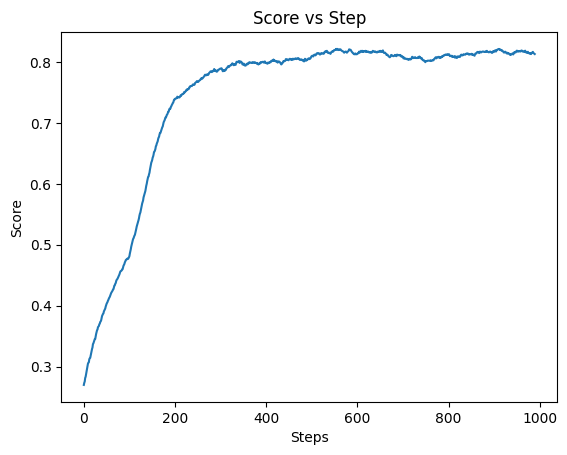

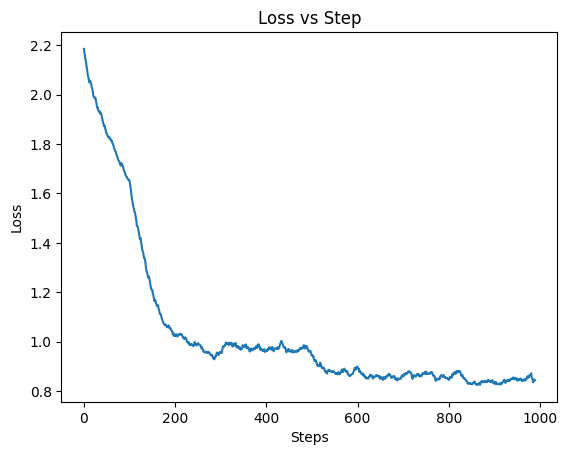

On problem type: multiplication


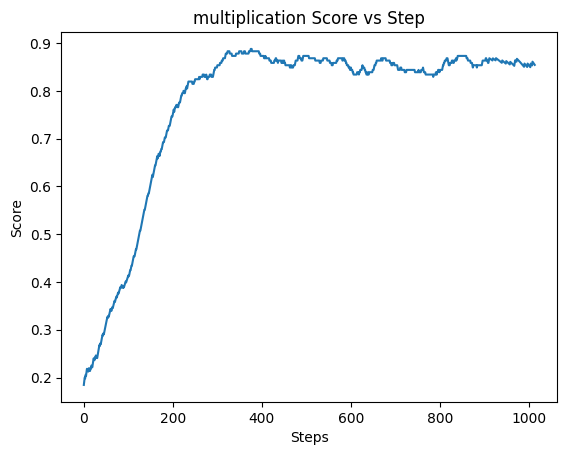

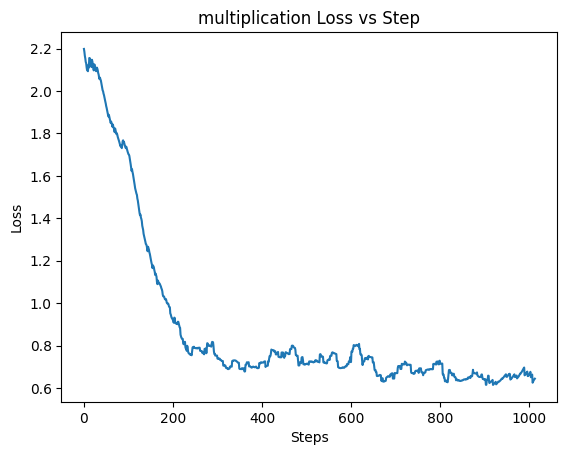

Final Score and Loss: 0.7613412228796844 0.9351072
On problem type: modulo


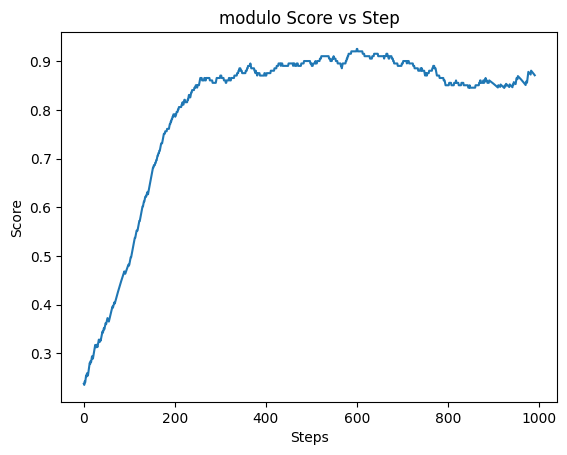

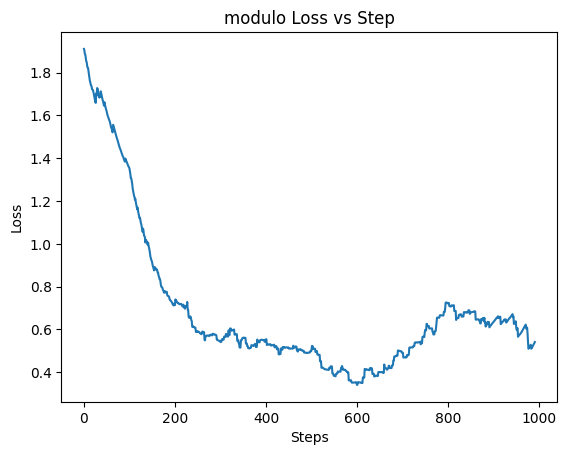

Final Score and Loss: 0.7923387096774194 0.7289382
On problem type: gcd


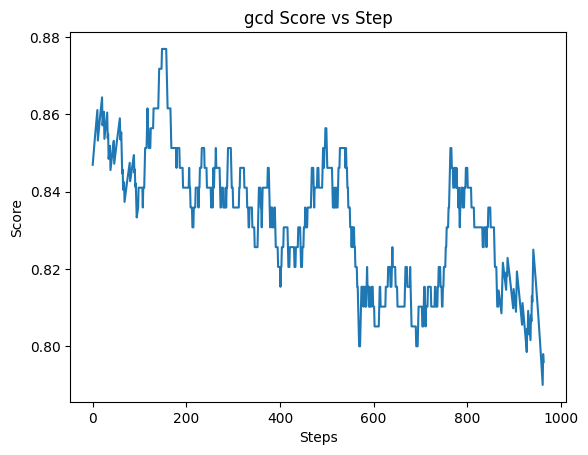

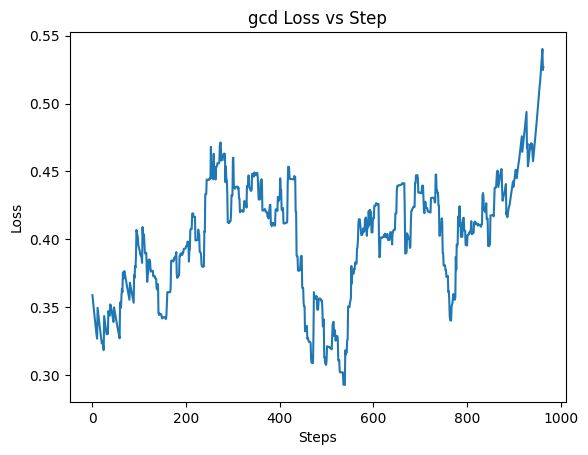

Final Score and Loss: 0.8309128630705395 0.41687828
On problem type: lcm


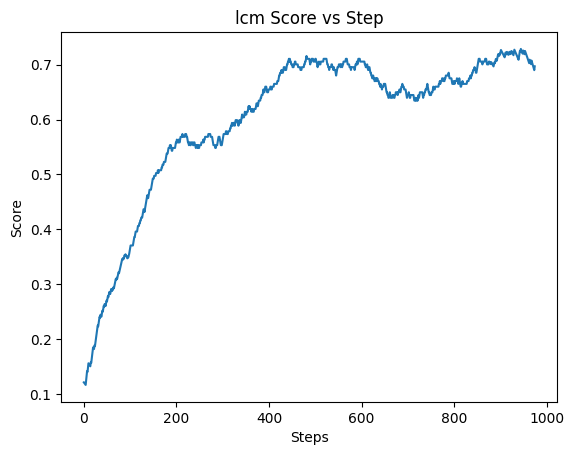

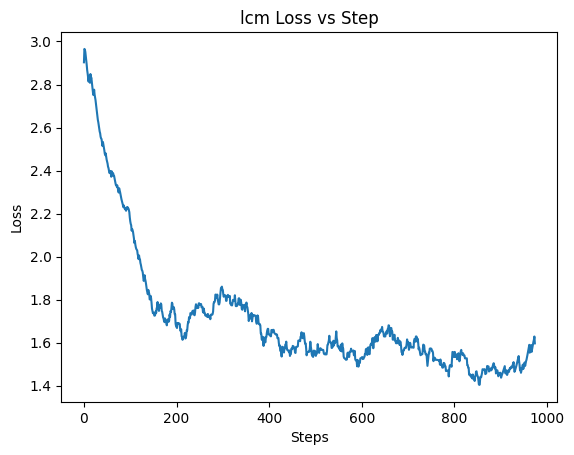

Final Score and Loss: 0.5876923076923077 1.7580702
On problem type: square_mod


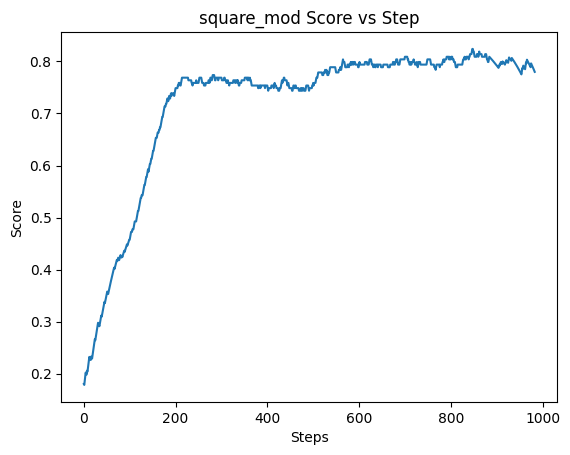

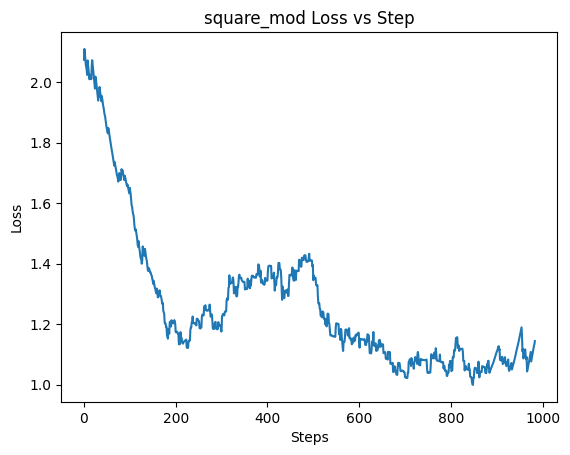

Final Score and Loss: 0.7073170731707317 1.2966045
On problem type: bitwise_and


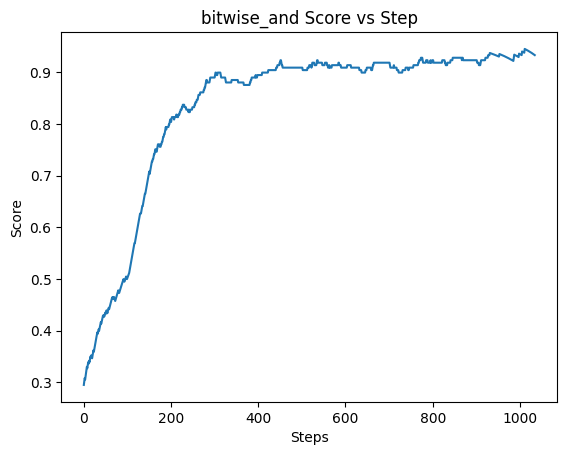

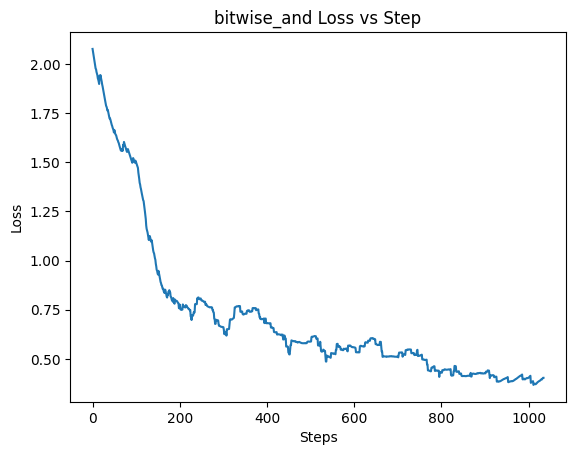

Final Score and Loss: 0.8222222222222222 0.75723445
On problem type: bitwise_xor


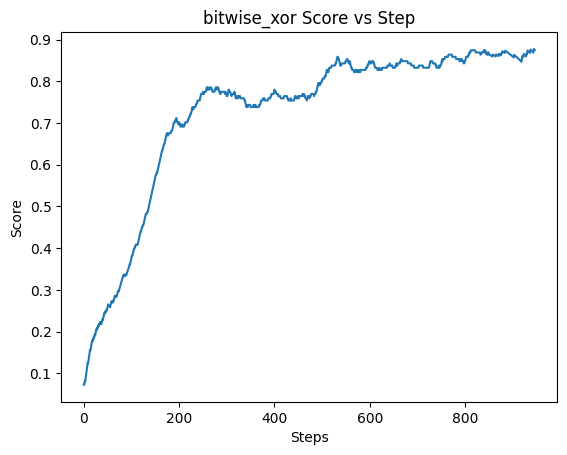

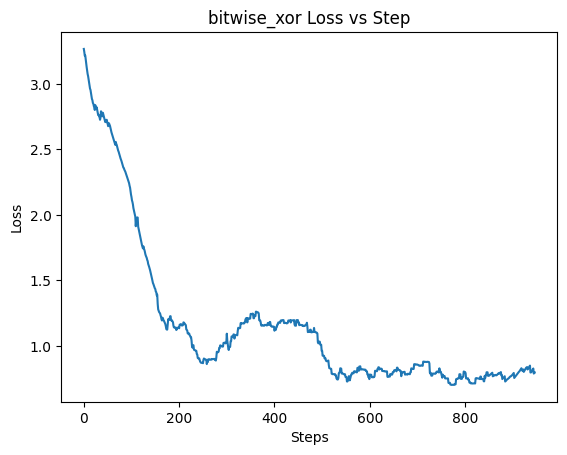

Final Score and Loss: 0.7127771911298838 1.2233492
On problem type: bitwise_or


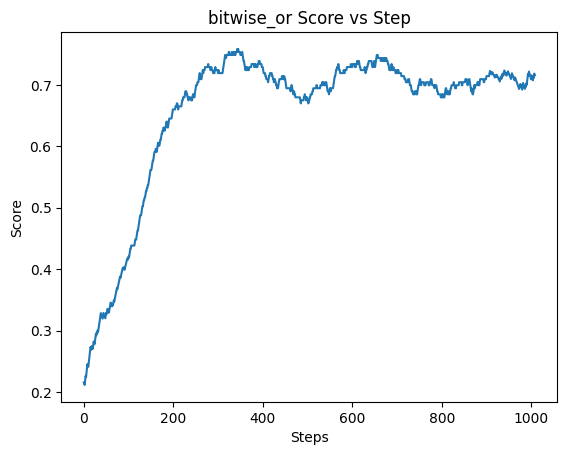

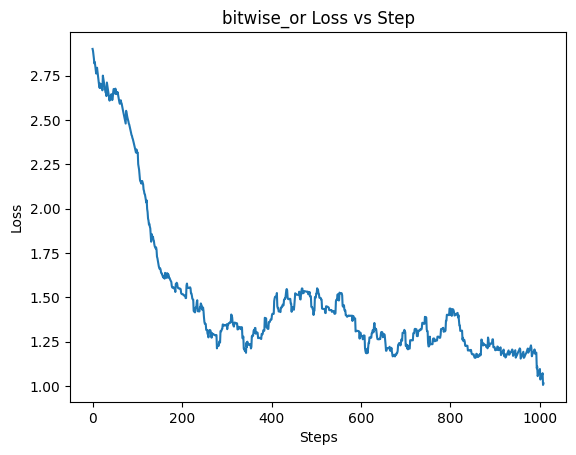

Final Score and Loss: 0.643211100099108 1.5668588


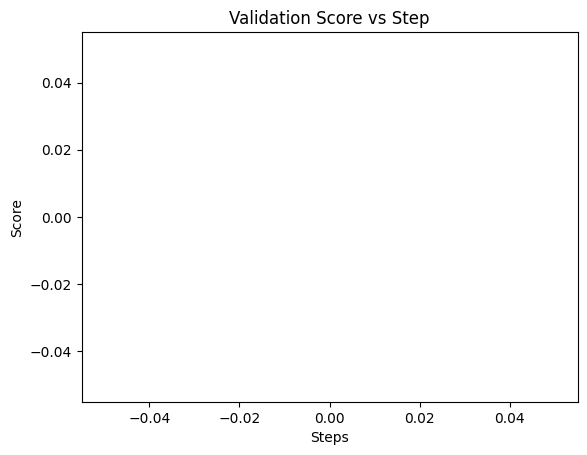

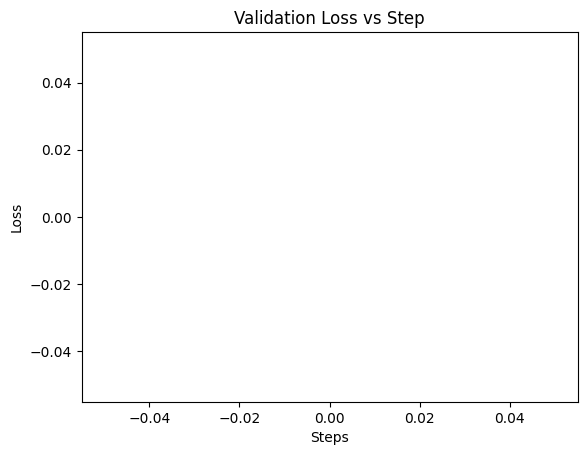

Training Complete


In [29]:
###################################################################################
############################## Plot Training Metrics ##############################
###################################################################################

if train_model:
    if save_model:
        # Add rms and skip connection paramters to decoder to be saved
        if rms_layer:
            generator.model.decoders.rms_layer   = nn.ModuleList(generator.model.rms_layers)
        if trainable_skip:
            generator.model.decoders.skip_weight = generator.model.skip_weights

        current_datetime = datetime.datetime.now()
        formatted_string = current_datetime.strftime("%Y_%m_%d")
        torch.save(generator.model.decoders, f"{curr_dir}/models/" + save_path.split(".pth")[0] + f"{formatted_string}" + ".pth")
        print("Saved", f"{curr_dir}/models/" + save_path.split(".pth")[0] + f"{formatted_string}" + ".pth")

    if not rms_layer and trainable_skip:

        print("Skip Weight strength after training:", generator.model.skip_weights.detach().cpu().float().numpy())

    plt.plot(create_smooth_data(np.array(scores), n=(step+1)//10))
    #plt.title(f"Score vs step (smoothing factor = {(step+1) // 10})")
    plt.title(f"Score vs Step")
    plt.xlabel("Steps")
    plt.ylabel("Score")
    if log_wandb:
        wandb.log({"score_vs_step": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    plt.plot(create_smooth_data(np.array(losses), n=(step+1)//10))
    #plt.title(f"Loss vs step (smoothing factor = {(step+1) // 10})")
    plt.title(f"Loss vs Step")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    if log_wandb:
        wandb.log({"loss_vs_step": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    if type(problem_type) == list:
        for pt in problem_type:
            print("On problem type:", pt)
            pt_scores = np.array(scores_per_pt[pt])
            pt_losses = np.array(losses_per_pt[pt])

            plt.plot(create_smooth_data(pt_scores, n=len(pt_scores)//10))
            #plt.title(f"{pt} Score vs step (smoothing factor = {len(pt_scores) // 10})")
            plt.title(f"{pt} Score vs Step")
            plt.xlabel("Steps")
            plt.ylabel("Score")
            if log_wandb:
                wandb.log({f"{pt}_score_vs_step": wandb.Image(plt)})  # Log to wandb
            else:
                plt.show()
            plt.close()

            plt.plot(create_smooth_data(pt_losses, n=len(pt_losses)//10))
            #plt.title(f"{pt} Loss vs step (smoothing factor = {len(pt_losses) // 10})")
            plt.title(f"{pt} Loss vs Step")
            plt.xlabel("Steps")
            plt.ylabel("Loss")
            if log_wandb:
                wandb.log({f"{pt}_loss_vs_step": wandb.Image(plt)})  # Log to wandb
            else:
                plt.show()
            plt.close()

            print("Final Score and Loss:", np.mean(pt_scores[:-10]), np.mean(pt_losses[:-10]))
            if log_wandb:
                wandb.log({f"final_score_{pt}": np.mean(pt_scores[:-10])})  # Log to wandb
                wandb.log({f"final_loss_{pt}" : np.mean(pt_losses[:-10])})  # Log to wandb

    if validate_model:
        plt.plot(create_smooth_data(np.array(val_scores), n=(step+1)//10))
        #plt.title(f"Score vs step (smoothing factor = {(step+1) // 10})")
        plt.title(f"Validation Score vs Step")
        plt.xlabel("Steps")
        plt.ylabel("Score")
        if log_wandb:
            wandb.log({"validation_score_vs_step": wandb.Image(plt)})  # Log to wandb
        else:
            plt.show()
        plt.close()

        plt.plot(create_smooth_data(np.array(val_losses), n=(step+1)//10))
        #plt.title(f"Loss vs step (smoothing factor = {(step+1) // 10})")
        plt.title(f"Validation Loss vs Step")
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        if log_wandb:
            wandb.log({"validation_loss_vs_step": wandb.Image(plt)})  # Log to wandb
        else:
            plt.show()
        plt.close()


    print("Training Complete")

In [37]:
test_baseline = 1

In [38]:
#####################################################################
############################## Testing ##############################
#####################################################################

if test_on_unrelated_questions:
    static_encoding = 0 # Set to false in order to get more samples for the testing phase
    multi_token_intervention = 1 # Set to true in order to get more samples for the testing phase


if test_model:
    generator.model.current_split = "test"

    testing_losses_per_pt_SYM = {}
    testing_losses_per_pt_LLM = {}
    testing_scores_per_pt_SYM = {}
    testing_scores_per_pt_LLM = {}

    if not testing_data_df_path:
        use_existing_questions = False
    else:
        use_existing_questions = True
        test_questions_df = pd.read_csv(testing_data_df_path)


    for pt in testing_problems:
        print("~~~~~~~~ Problem Type:", pt, "~~~~~~~~")
        if use_existing_questions:
            pt_df = test_questions_df[test_questions_df.problem_type == pt]
            new_num_steps = math.ceil(len(pt_df) / (testing_n_samples * testing_inference_to_backprop_ratio)) # Change the number of steps so that the entire df is used once
            print(f"Testing dataframe of problem type {pt} with {len(pt_df)} rows detected, changing the number of steps from {testing_num_steps} to {new_num_steps}")

            testing_num_steps = new_num_steps

            # TODO: Temporary hack fix to set the number of samples (n_samples) fed into the LLM to 1. This won't change performance, but forces the batch_size fed into the LLM to be 1
            testing_inference_to_backprop_ratio *= testing_n_samples
            testing_n_samples = 1
        else:
            pt_df = None

        if test_baseline != 2:
            # Symbolic LLM
            generator.model.bypass_symbolic = False
            generator.model.add_noise       = False
            losses, scores, responses  = evaluate_model(testing_n_samples=testing_n_samples,
                                                        testing_num_steps=testing_num_steps,
                                                        testing_temperature=testing_temperature,
                                                        problem_type=pt, generator=generator, criterion=criterion,
                                                        inference_to_backprop_ratio=testing_inference_to_backprop_ratio,
                                                        complexity=complexity, cot=cot, df=pt_df,
                                                        testing_steps_to_print=testing_steps_to_print, testing_verbose=testing_verbose)

            testing_losses_per_pt_SYM[pt] = losses
            testing_scores_per_pt_SYM[pt] = scores

            symbolic_output_text = plot_results(losses, scores, pt, generator.model.bypass_symbolic)
            if log_wandb:
                wandb.log({f"testing_losses_per_pt_SYM_{pt}": testing_losses_per_pt_SYM[pt]})
                wandb.log({f"average_testing_loss_SYM_{pt}": np.mean(testing_losses_per_pt_SYM[pt])})
                wandb.log({f"testing_scores_per_pt_SYM_{pt}": testing_scores_per_pt_SYM[pt]})
                wandb.log({f"average_testing_score_SYM_{pt}": np.mean(testing_scores_per_pt_SYM[pt])})
                wandb.log({f"symbolic_output_text_{pt}": symbolic_output_text})

        if test_baseline != 0:
            # Standard LLM
            generator.model.bypass_symbolic = True
            generator.model.add_noise       = False
            losses, scores, responses  = evaluate_model(testing_n_samples=testing_n_samples,
                                                        testing_num_steps=testing_num_steps,
                                                        testing_temperature=testing_temperature,
                                                        problem_type=pt, generator=generator, criterion=criterion,
                                                        inference_to_backprop_ratio=testing_inference_to_backprop_ratio,
                                                        complexity=complexity, cot=cot, df=pt_df,
                                                        testing_steps_to_print=testing_steps_to_print, testing_verbose=testing_verbose)
            testing_losses_per_pt_LLM[pt] = losses
            testing_scores_per_pt_LLM[pt] = scores

            standard_output_text = plot_results(losses, scores, pt, generator.model.bypass_symbolic)
            if log_wandb:
                wandb.log({f"testing_losses_per_pt_LLM_{pt}": testing_losses_per_pt_LLM[pt]})
                wandb.log({f"average_testing_loss_LLM_{pt}": np.mean(testing_losses_per_pt_LLM[pt])})
                wandb.log({f"testing_scores_per_pt_LLM_{pt}": testing_scores_per_pt_LLM[pt]})
                wandb.log({f"average_testing_score_LLM_{pt}": np.mean(testing_scores_per_pt_LLM[pt])})
                wandb.log({f"standard_output_text_{pt}": standard_output_text})


    for pt in testing_problems:
        if testing_verbose:
            print("~~~~~~~~ Problem Type:", pt, "~~~~~~~~")
        if test_baseline != 2:
            plt.hist(testing_losses_per_pt_SYM[pt], bins=75)
            plt.xlabel("Loss")
            plt.title(f"{pt} Symbolic Loss Histogram")
            if testing_verbose:
                plt.show()
            if log_wandb:
                wandb.log({f"{pt}_symbolic_loss_histogram": wandb.Image(plt)})  # Log to wandb
            plt.close()

        if test_baseline != 0:
            plt.hist(testing_losses_per_pt_LLM[pt], bins=75)
            plt.xlabel("Loss")
            plt.title(f"{pt} Standard Loss Histogram")
            if testing_verbose:
                plt.show()
            if log_wandb:
                wandb.log({f"{pt}_standard_loss_histogram": wandb.Image(plt)})  # Log to wandb
            plt.close()


~~~~~~~~ Problem Type: addition ~~~~~~~~

 Mean score and loss of symbolic LLM on addition: 74.0 ± 43.8634, 0.653 ± 1.156

 Mean score and loss of standard LLM on addition: 70.0 ± 45.8258, 0.648 ± 0.7972
~~~~~~~~ Problem Type: division ~~~~~~~~

 Mean score and loss of symbolic LLM on division: 80.0 ± 40.0, 0.643 ± 1.3041

 Mean score and loss of standard LLM on division: 81.0 ± 39.2301, 0.5 ± 0.7767
~~~~~~~~ Problem Type: multiplication ~~~~~~~~

 Mean score and loss of symbolic LLM on multiplication: 88.0 ± 32.4962, 1.19 ± 2.4186

 Mean score and loss of standard LLM on multiplication: 2.0 ± 14.0, 6.842 ± 1.3948
~~~~~~~~ Problem Type: modulo ~~~~~~~~

 Mean score and loss of symbolic LLM on modulo: 91.0 ± 28.6182, 0.947 ± 2.3182

 Mean score and loss of standard LLM on modulo: 28.0 ± 44.8999, 3.892 ± 2.3218
~~~~~~~~ Problem Type: gcd ~~~~~~~~

 Mean score and loss of symbolic LLM on gcd: 83.0 ± 37.5633, 0.538 ± 1.1317

 Mean score and loss of standard LLM on gcd: 49.0 ± 49.99, 2.342 

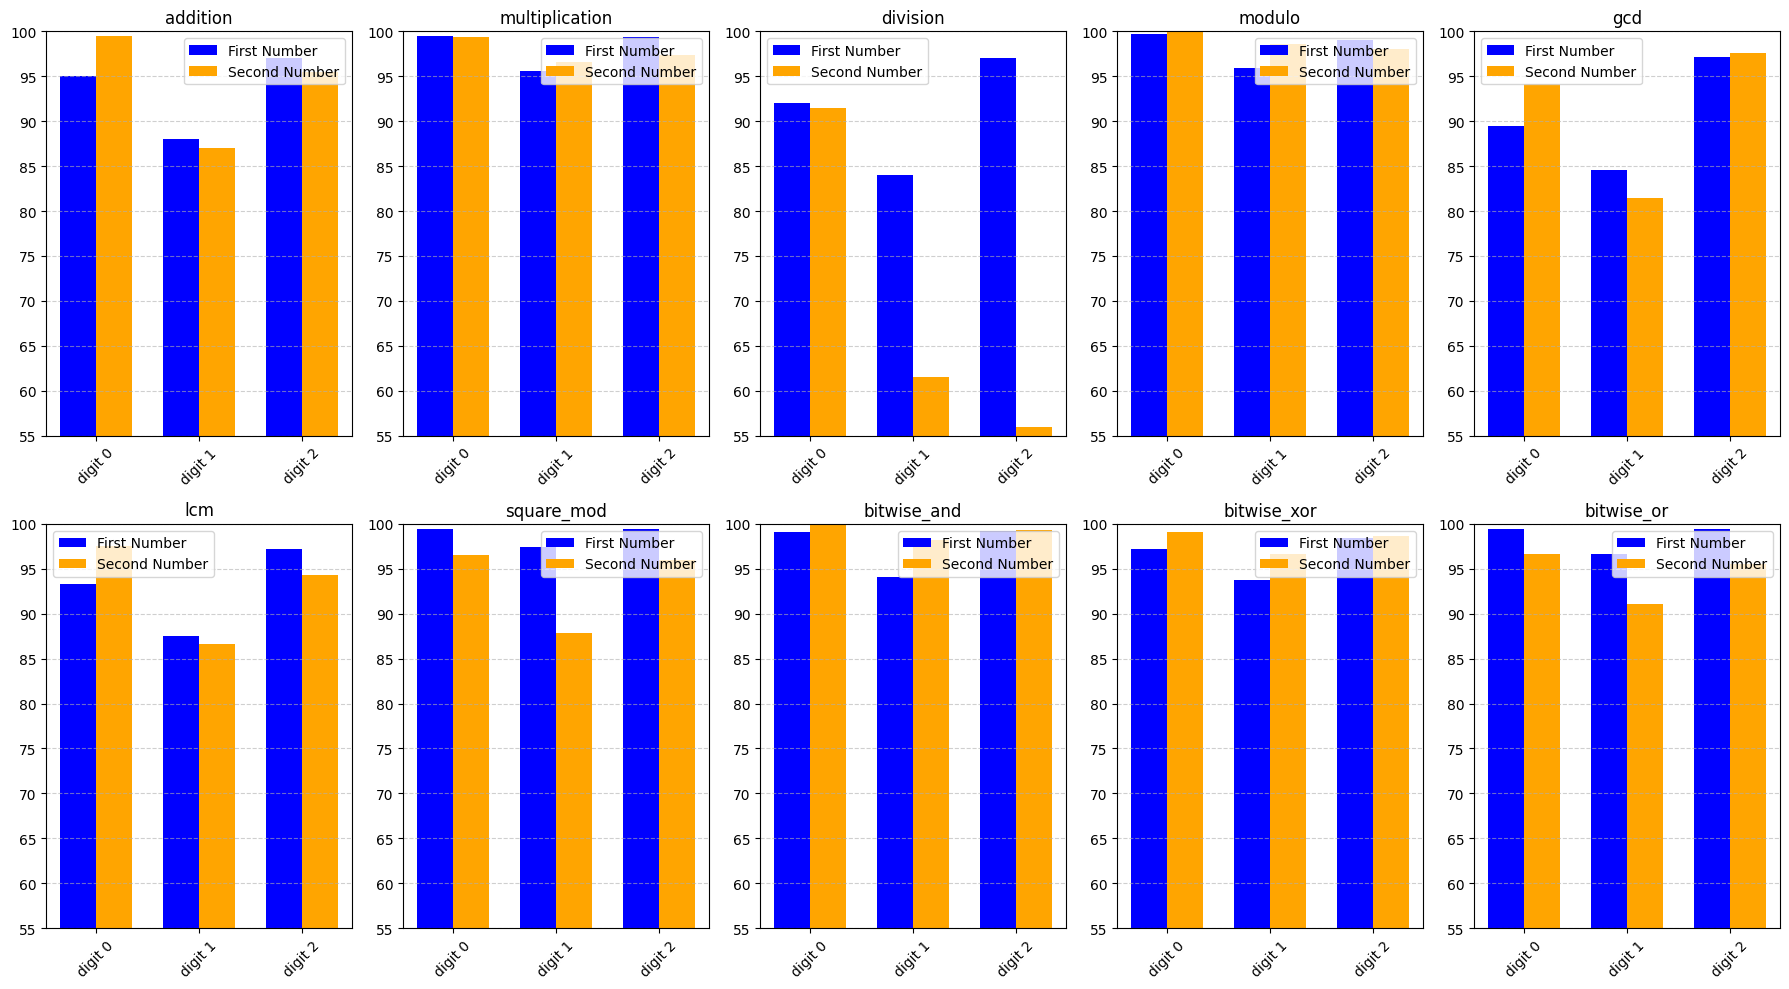

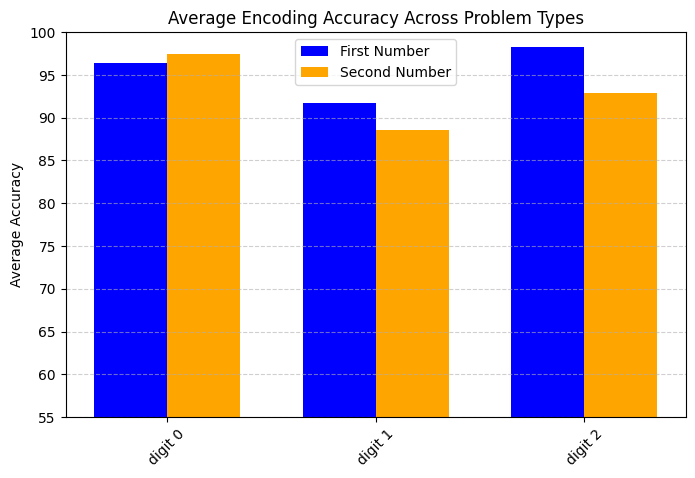

In [35]:
#####################################################################
###################### Encoder Accuracy Plots #######################
#####################################################################


if generator.model.calculate_encoding_accuracy:
    average_accuracy_per_pt = {}

    problem_types = list(generator.model.encoding_accuracy.keys())
    digits = list(generator.model.encoding_accuracy[problem_types[0]].keys())

    minval = 100
    maxval = 0

    for pt in problem_types:
        average_accuracy_per_pt[pt] = {}
        for d in digits:
            average_accuracy_per_pt[pt][d] = [0, 0]
            average_accuracy_per_pt[pt][d][0] = np.mean(generator.model.encoding_accuracy[pt][d]["first_number"])*100
            average_accuracy_per_pt[pt][d][1] = np.mean(generator.model.encoding_accuracy[pt][d]["second_number"])*100

            curr_min = min(np.mean(generator.model.encoding_accuracy[pt][d]["first_number"])  * 100,
                           np.mean(generator.model.encoding_accuracy[pt][d]["second_number"]) * 100)
            curr_max = max(np.mean(generator.model.encoding_accuracy[pt][d]["first_number"])  * 100,
                           np.mean(generator.model.encoding_accuracy[pt][d]["second_number"]) * 100)

            if minval > curr_min:
                minval = curr_min
            if maxval < curr_max:
                maxval = curr_max

    minval = minval // 5 * 5
    maxval = min(100, (maxval // 5 + 1) * 5)

    # Define colors for first and second number
    colors = ['blue', 'orange']

    # Create subplots (one per problem type)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 10))  # Adjust grid based on the number of problem types
    axes = axes.flatten()

    for i, (pt, digits_data) in enumerate(average_accuracy_per_pt.items()):
        ax = axes[i]

        digits = list(digits_data.keys())  # ['digit 0', 'digit 1', ...]
        x = np.arange(len(digits))  # X-axis positions

        first_num = [digits_data[d][0] for d in digits]  # First number accuracies
        second_num = [digits_data[d][1] for d in digits]  # Second number accuracies

        width = 0.35  # Width of bars
        ax.bar(x - width/2, first_num, width, label='First Number', color=colors[0])
        ax.bar(x + width/2, second_num, width, label='Second Number', color=colors[1])

        # Formatting
        ax.set_xticks(x)
        ax.set_xticklabels(digits, rotation=45)
        ax.set_ylim(minval, maxval)
        ax.set_title(pt)
        ax.legend()
        ax.grid(axis="y", linestyle="--", alpha=0.6)

    # Adjust layout and show the plot
    plt.tight_layout()
    if log_wandb:
        wandb.log({f"per_pt_encoding_accuracy": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

    # Compute average per digit across all problem types
    avg_first_number = []
    avg_second_number = []

    for d in digits:
        first_vals = [average_accuracy_per_pt[pt][d][0] for pt in average_accuracy_per_pt]
        second_vals = [average_accuracy_per_pt[pt][d][1] for pt in average_accuracy_per_pt]
        avg_first_number.append(np.mean(first_vals))
        avg_second_number.append(np.mean(second_vals))

    # Plotting
    x = np.arange(len(digits))  # X-axis positions
    width = 0.35  # Bar width

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width/2, avg_first_number, width, label='First Number', color='blue')
    ax.bar(x + width/2, avg_second_number, width, label='Second Number', color='orange')

    # Formatting
    ax.set_xticks(x)
    ax.set_xticklabels(digits, rotation=45)
    ax.set_ylim(minval, maxval)  # Adjust y-axis for better visibility
    ax.set_ylabel("Average Accuracy")
    ax.set_title("Average Encoding Accuracy Across Problem Types")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    # Show the plot
    if log_wandb:
        wandb.log({f"all_pts_encoding_accuracy": wandb.Image(plt)})  # Log to wandb
    else:
        plt.show()
    plt.close()

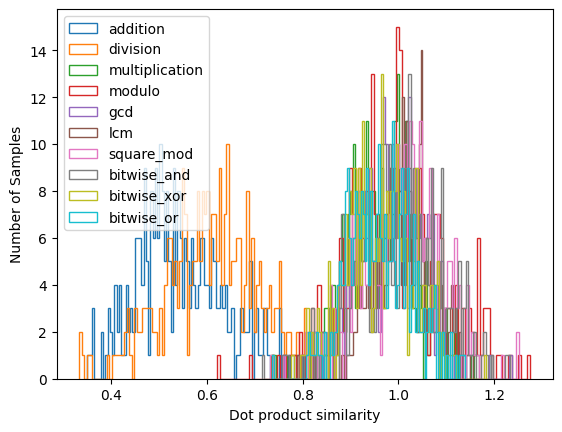

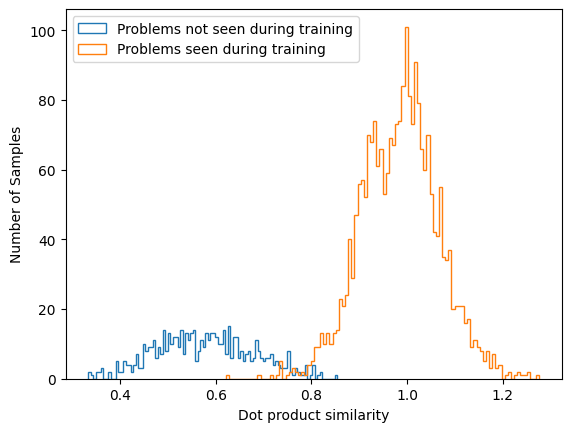

Number of trained problems with different actual problem types and maximum score identified problem types: 0


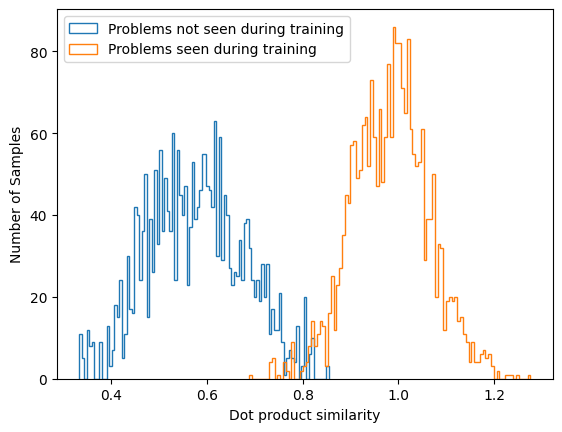

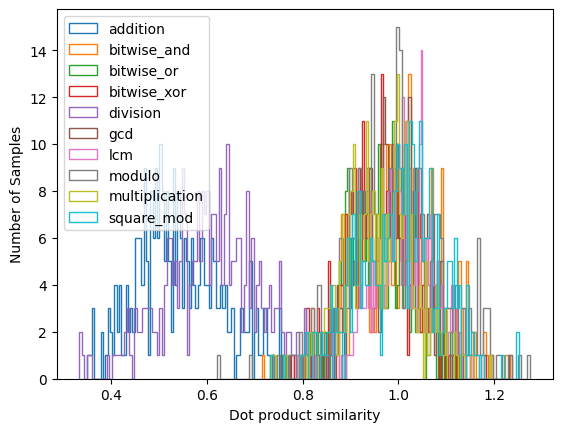

In [41]:
#####################################################################
################### Problem Type Similarity Plots ###################
#####################################################################

if record_score_per_problem and test_baseline != 2 and not lora_baseline:
    if record_score_per_problem == 1:
        file_path = f"{curr_dir}/outputs/score_per_problem_training_{wandb.run.id if log_wandb else run_name}.txt"
    if record_score_per_problem == 2:
        file_path = f"{curr_dir}/outputs/score_per_problem_testing_{wandb.run.id if log_wandb else run_name}.txt"
    if record_score_per_problem == 3:
        file_path = f"{curr_dir}/outputs/score_per_problem_training_and_testing_{wandb.run.id if log_wandb else run_name}.txt"
    df = pd.read_csv(file_path)
    #os.remove(file_path)

    df['training_item'] = [i for i in range(len(df) // len(generator.model.SE.possible_problems)) 
                             for j in range(len(generator.model.SE.possible_problems))]

    untrained_pts = sorted(list(set(testing_problems) - set(generator.model.training_problems)))
    trained_pts   = generator.model.training_problems
    bins = 100
    leg = []
    for pt in untrained_pts:
        if len(df[df.actual_problem_type.isin([pt])]) == 0:
            continue
        leg += [pt]
        # Maximum score per question, for actual_problem_type == pt rows
        plt.hist(df[df.actual_problem_type.isin([pt])].pivot_table(
            index="training_item", values="score", aggfunc="max").score, bins=bins, histtype="step")
    for pt in trained_pts:
        if len(df[df.actual_problem_type.isin([pt])]) == 0:
            continue
        leg += [pt]
        # Maximum score per question, for actual_problem_type == pt rows
        plt.hist(df[df.actual_problem_type.isin([pt])].  pivot_table(
            index="training_item", values="score", aggfunc="max").score, bins=bins, histtype="step")
    plt.xlabel("Dot product similarity")
    plt.ylabel("Number of Samples")
    plt.legend(leg)
    if log_wandb:
        wandb.log({f"problem_type_similarity_histogram_per_problem_type": wandb.Image(plt)})
    else:
        plt.show()
    plt.close()

    bins = 100
    if df[df.actual_problem_type.isin(untrained_pts)].shape[0]:
        # Maximum score per question, for untrained problem type rows
        plt.hist(df[df.actual_problem_type.isin(untrained_pts)].pivot_table(
            index="training_item", values="score", aggfunc="max").score, bins=bins, histtype="step")
    if df[df.actual_problem_type.isin(trained_pts)].shape[0]:
        # Maximum score per question, for trained problem type rows
        plt.hist(df[df.actual_problem_type.isin(trained_pts)].  pivot_table(
            index="training_item", values="score", aggfunc="max").score, bins=bins, histtype="step")
    plt.xlabel("Dot product similarity")
    plt.ylabel("Number of Samples")
    plt.legend(["Problems not seen during training", "Problems seen during training"], loc="upper left")
    if log_wandb:
        wandb.log({f"problem_type_similarity_histogram": wandb.Image(plt)})
    else:
        plt.show()
    plt.close()

    if df[df.actual_problem_type.isin(untrained_pts)].shape[0]:
        if log_wandb:
            wandb.log({"untrained_problem_scores": df[df.actual_problem_type.isin(untrained_pts)].pivot_table(
                           index="training_item", values="score", aggfunc="max").score.tolist(),
                       "trained_problem_scores":   df[df.actual_problem_type.isin(trained_pts)]  .pivot_table(
                           index="training_item", values="score", aggfunc="max").score.tolist()})
    else:
        if log_wandb:
            wandb.log({"trained_problem_scores":   df[df.actual_problem_type.isin(trained_pts)]  .pivot_table(
                index="training_item", values="score", aggfunc="max").score.tolist()})

    result = (
        df[df.actual_problem_type.isin(trained_pts)]
        .groupby("training_item")
        .apply(lambda x: x.loc[x['score'].idxmax()], include_groups=False)
        .reset_index(drop=True)
    )

    print("Number of trained problems with different actual problem types and maximum score identified problem types:", 
            sum(result['actual_problem_type'] != result['predicted_problem_type']))
    if log_wandb:
        wandb.log({"different_actual_problem_types_count": sum(result['actual_problem_type'] != result['predicted_problem_type'])})

    train_problem_scores = df[df.actual_problem_type.isin(generator.model.training_problems)].pivot_table(
        index="training_item", values="score", aggfunc="max")
    test_problem_scores = df[~df.actual_problem_type.isin(generator.model.training_problems)].pivot_table(
        index="training_item", values="score", aggfunc="max")

    min_dataset_size = max(len(train_problem_scores), len(test_problem_scores)) * 1

    plt.hist(test_problem_scores.sample(min_dataset_size, replace=True).score, bins=bins, histtype="step")
    plt.hist(train_problem_scores.sample(min_dataset_size, replace=True).score, bins=bins, histtype="step")
    plt.xlabel("Dot product similarity")
    plt.ylabel("Number of Samples")
    plt.legend([ "Problems not seen during training", "Problems seen during training"])
    if log_wandb:
        wandb.log({f"training_vs_testing_pt_similarity": wandb.Image(plt)})
    else:
        plt.show()
    plt.close()

    leg = []
    for pt in sorted(set(df.actual_problem_type)):
        plt.hist(df[df.actual_problem_type.isin([pt])].  pivot_table(
            index="training_item", values="score", aggfunc="max").score, bins=bins, histtype="step")
        leg += [pt]
    plt.xlabel("Dot product similarity")
    plt.ylabel("Number of Samples")
    plt.legend(leg)
    if log_wandb:
        wandb.log({f"training_vs_testing_seperated_pt_similarity": wandb.Image(plt)})
    else:
        plt.show()
    plt.close()
